In [572]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RepeatedKFold

import warnings
warnings.filterwarnings("ignore")

In [574]:
# read in dataset
dfWalk = pd.read_csv('/Users/austincoffelt/Documents/Rent-Walk-local/EPA_SmartLocationDatabase_V3_Jan_2021_Final.csv')
dfWalk.head()

,OBJECTID,GEOID10,GEOID20,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,CSA,CSA_Name,CBSA,...,D5DRI,D5DE,D5DEI,D2A_Ranked,D2B_Ranked,D3B_Ranked,D4A_Ranked,NatWalkInd,Shape_Length,Shape_Area
0,1,4.811300e+11,4.811300e+11,48,113,7825,4,206.0,"Dallas-Fort Worth, TX-OK",19100.0,...,0.184697,0.000476,0.137707,6,14,15,17,14.000000,3110.360820,297836.0831
1,2,4.811300e+11,4.811300e+11,48,113,7825,2,206.0,"Dallas-Fort Worth, TX-OK",19100.0,...,0.323221,0.000801,0.231868,3,10,12,14,10.833333,3519.469110,484945.1466
2,3,4.811300e+11,4.811300e+11,48,113,7825,3,206.0,"Dallas-Fort Worth, TX-OK",19100.0,...,0.314628,0.000736,0.213146,1,1,7,17,8.333333,1697.091802,106705.9281
3,4,4.811300e+11,4.811300e+11,48,113,7824,1,206.0,"Dallas-Fort Worth, TX-OK",19100.0,...,0.229821,0.000708,0.205018,16,10,17,17,15.666667,2922.609204,481828.4303
4,5,4.811300e+11,4.811300e+11,48,113,7824,2,206.0,"Dallas-Fort Worth, TX-OK",19100.0,...,0.164863,0.000433,0.125296,4,7,11,14,10.166667,3731.971773,687684.7752


In [575]:
# change state, county, tract, and blk group to strings
dfWalk.loc[:, ['STATEFP', 'COUNTYFP', 'TRACTCE', 'BLKGRPCE']] = dfWalk.loc[:, ['STATEFP', 'COUNTYFP', 'TRACTCE', 'BLKGRPCE']].astype('str')

In [576]:
# add 0s to the front to create the geoIDs
for i in range(len(dfWalk)):
    dfWalk.loc[i, 'STATEFP'] = dfWalk.loc[i, 'STATEFP'].zfill(2)
    dfWalk.loc[i, 'COUNTYFP'] = dfWalk.loc[i, 'COUNTYFP'].zfill(3)
    dfWalk.loc[i, 'TRACTCE'] = dfWalk.loc[i, 'TRACTCE'].zfill(6)
    
dfWalk.head()

,OBJECTID,GEOID10,GEOID20,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,CSA,CSA_Name,CBSA,...,D5DRI,D5DE,D5DEI,D2A_Ranked,D2B_Ranked,D3B_Ranked,D4A_Ranked,NatWalkInd,Shape_Length,Shape_Area
0,1,4.811300e+11,4.811300e+11,48,113,007825,4,206.0,"Dallas-Fort Worth, TX-OK",19100.0,...,0.184697,0.000476,0.137707,6,14,15,17,14.000000,3110.360820,297836.0831
1,2,4.811300e+11,4.811300e+11,48,113,007825,2,206.0,"Dallas-Fort Worth, TX-OK",19100.0,...,0.323221,0.000801,0.231868,3,10,12,14,10.833333,3519.469110,484945.1466
2,3,4.811300e+11,4.811300e+11,48,113,007825,3,206.0,"Dallas-Fort Worth, TX-OK",19100.0,...,0.314628,0.000736,0.213146,1,1,7,17,8.333333,1697.091802,106705.9281
3,4,4.811300e+11,4.811300e+11,48,113,007824,1,206.0,"Dallas-Fort Worth, TX-OK",19100.0,...,0.229821,0.000708,0.205018,16,10,17,17,15.666667,2922.609204,481828.4303
4,5,4.811300e+11,4.811300e+11,48,113,007824,2,206.0,"Dallas-Fort Worth, TX-OK",19100.0,...,0.164863,0.000433,0.125296,4,7,11,14,10.166667,3731.971773,687684.7752


In [577]:
# create realGeoID for merging
dfWalk['realGEOID'] = '1500000US' + dfWalk['STATEFP'] + dfWalk['COUNTYFP'] + dfWalk['TRACTCE'] + dfWalk['BLKGRPCE']
dfWalk['county'] = dfWalk['STATEFP'] + dfWalk['COUNTYFP']
dfWalk.head()

,OBJECTID,GEOID10,GEOID20,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,CSA,CSA_Name,CBSA,...,D5DEI,D2A_Ranked,D2B_Ranked,D3B_Ranked,D4A_Ranked,NatWalkInd,Shape_Length,Shape_Area,realGEOID,county
0,1,4.811300e+11,4.811300e+11,48,113,007825,4,206.0,"Dallas-Fort Worth, TX-OK",19100.0,...,0.137707,6,14,15,17,14.000000,3110.360820,297836.0831,1500000US481130078254,48113
1,2,4.811300e+11,4.811300e+11,48,113,007825,2,206.0,"Dallas-Fort Worth, TX-OK",19100.0,...,0.231868,3,10,12,14,10.833333,3519.469110,484945.1466,1500000US481130078252,48113
2,3,4.811300e+11,4.811300e+11,48,113,007825,3,206.0,"Dallas-Fort Worth, TX-OK",19100.0,...,0.213146,1,1,7,17,8.333333,1697.091802,106705.9281,1500000US481130078253,48113
3,4,4.811300e+11,4.811300e+11,48,113,007824,1,206.0,"Dallas-Fort Worth, TX-OK",19100.0,...,0.205018,16,10,17,17,15.666667,2922.609204,481828.4303,1500000US481130078241,48113
4,5,4.811300e+11,4.811300e+11,48,113,007824,2,206.0,"Dallas-Fort Worth, TX-OK",19100.0,...,0.125296,4,7,11,14,10.166667,3731.971773,687684.7752,1500000US481130078242,48113


In [578]:
# select and rename the most important columns of our dataframe
imptCols = ['realGEOID','county', 'NatWalkInd', 'STATEFP', 'CountHU', 'P_WrkAge', 'Pct_AO0',
            'Pct_AO2p', 'R_LowWageWk', 'R_HiWageWk', 'R_PCTLOWWAGE', 'TotEmp', 'D1A', 
            'D1B', 'D1D', 'D2A_JPHH', 'D5AR', 'D5CRI']
dfWalk = dfWalk.loc[:, imptCols]
dfWalk = dfWalk.rename({'NatWalkInd':'Walk_Index',
                        'STATEFP':'state',
                        'CountHU':'count_housing_units',
                        'P_WrkAge':'percentage_work_age',
                        'Pct_AO0':'percent_no_car',
                        'Pct_AO2p':'percent_two_car',
                        'R_LowWageWk':'count_low_wage_workers',
                        'R_HiWageWk':'count_high_wage_workers',
                        'R_PCTLOWWAGE':'percent_low_wage_workers',
                        'D1A':'housing_density',
                        'D1B':'population_density',
                        'D1D':'employent_housing_density',
                        'D2A_JPHH':'jobs_per_household',
                        'D5AR':'jobs_within_45_minutes_auto',
                        'D5CRI':'regional_centrality'}, axis = 1)
dfWalk.head()

,realGEOID,county,Walk_Index,state,count_housing_units,percentage_work_age,percent_no_car,percent_two_car,count_low_wage_workers,count_high_wage_workers,percent_low_wage_workers,TotEmp,housing_density,population_density,employent_housing_density,jobs_per_household,jobs_within_45_minutes_auto,regional_centrality
0,1500000US481130078254,48113,14.000000,48,460.0,0.549,0.163121,0.744681,99,191,0.240291,66,6.250422,16.332625,7.147222,0.156028,433601,0.785893
1,1500000US481130078252,48113,10.833333,48,409.0,0.466,0.000000,0.589242,76,212,0.192405,25,3.430799,5.955666,3.640506,0.061125,386504,0.700531
2,1500000US481130078253,48113,8.333333,48,365.0,0.811,0.057751,0.507599,136,138,0.293737,0,13.843035,27.951553,13.843035,0.000000,404573,0.733281
3,1500000US481130078241,48113,15.666667,48,384.0,0.638,0.000000,0.888021,60,302,0.139211,253,3.225246,7.592767,5.350213,0.658854,423099,0.766859
4,1500000US481130078242,48113,10.166667,48,343.0,0.506,0.014577,0.790087,91,404,0.157168,32,2.305992,6.373413,2.521128,0.093294,335700,0.608450


In [579]:
# change numbers to States
dfWalk.loc[dfWalk['state'] == '01', 'state'] = 'Alabama' 
dfWalk.loc[dfWalk['state'] == '02', 'state'] = 'Alaska'
dfWalk.loc[dfWalk['state'] == '04', 'state'] = 'Arizona'
dfWalk.loc[dfWalk['state'] == '05', 'state'] = 'Arkansas'
dfWalk.loc[dfWalk['state'] == '06', 'state'] = 'California'
dfWalk.loc[dfWalk['state'] == '08', 'state'] = 'Colorado'
dfWalk.loc[dfWalk['state'] == '09', 'state'] = 'Connecticut'
dfWalk.loc[dfWalk['state'] == '10', 'state'] = 'Deleware'
dfWalk.loc[dfWalk['state'] == '11', 'state'] = 'District of Columbia'
dfWalk.loc[dfWalk['state'] == '12', 'state'] = 'Florida'
dfWalk.loc[dfWalk['state'] == '13', 'state'] = 'Georgia'
dfWalk.loc[dfWalk['state'] == '15', 'state'] = 'Hawaii'
dfWalk.loc[dfWalk['state'] == '16', 'state'] = 'Idaho'
dfWalk.loc[dfWalk['state'] == '17', 'state'] = 'Illinois'
dfWalk.loc[dfWalk['state'] == '18', 'state'] = 'Indiana'
dfWalk.loc[dfWalk['state'] == '19', 'state'] = 'Iowa'
dfWalk.loc[dfWalk['state'] == '20', 'state'] = 'Kansas'
dfWalk.loc[dfWalk['state'] == '21', 'state'] = 'Kentucky'
dfWalk.loc[dfWalk['state'] == '22', 'state'] = 'Louisiana'
dfWalk.loc[dfWalk['state'] == '23', 'state'] = 'Maine'
dfWalk.loc[dfWalk['state'] == '24', 'state'] = 'Maryland'
dfWalk.loc[dfWalk['state'] == '25', 'state'] = 'Massachusetts'
dfWalk.loc[dfWalk['state'] == '26', 'state'] = 'Michigan'
dfWalk.loc[dfWalk['state'] == '27', 'state'] = 'Minnesota'
dfWalk.loc[dfWalk['state'] == '28', 'state'] = 'Mississippi'
dfWalk.loc[dfWalk['state'] == '29', 'state'] = 'Missouri'
dfWalk.loc[dfWalk['state'] == '30', 'state'] = 'Montana'
dfWalk.loc[dfWalk['state'] == '31', 'state'] = 'Nebraska'
dfWalk.loc[dfWalk['state'] == '32', 'state'] = 'Nevada'
dfWalk.loc[dfWalk['state'] == '33', 'state'] = 'New Hampshire'
dfWalk.loc[dfWalk['state'] == '34', 'state'] = 'New Jersey'
dfWalk.loc[dfWalk['state'] == '35', 'state'] = 'New Mexico'
dfWalk.loc[dfWalk['state'] == '36', 'state'] = 'New York'
dfWalk.loc[dfWalk['state'] == '37', 'state'] = 'North Carolina'
dfWalk.loc[dfWalk['state'] == '38', 'state'] = 'North Dakota'
dfWalk.loc[dfWalk['state'] == '39', 'state'] = 'Ohio'
dfWalk.loc[dfWalk['state'] == '40', 'state'] = 'Oklahoma'
dfWalk.loc[dfWalk['state'] == '41', 'state'] = 'Oregon'
dfWalk.loc[dfWalk['state'] == '42', 'state'] = 'Pennsylvania'
dfWalk.loc[dfWalk['state'] == '44', 'state'] = 'Rhode Island'
dfWalk.loc[dfWalk['state'] == '45', 'state'] = 'South Carolian'
dfWalk.loc[dfWalk['state'] == '46', 'state'] = 'South Dakota'
dfWalk.loc[dfWalk['state'] == '47', 'state'] = 'Tennessee'
dfWalk.loc[dfWalk['state'] == '48', 'state'] = 'Texas'
dfWalk.loc[dfWalk['state'] == '49', 'state'] = 'Utah'
dfWalk.loc[dfWalk['state'] == '50', 'state'] = 'Vermont'
dfWalk.loc[dfWalk['state'] == '51', 'state'] = 'Virginia'
dfWalk.loc[dfWalk['state'] == '53', 'state'] = 'Washington'
dfWalk.loc[dfWalk['state'] == '54', 'state'] = 'West Virginia'
dfWalk.loc[dfWalk['state'] == '55', 'state'] = 'Wisconsin'
dfWalk.loc[dfWalk['state'] == '56', 'state'] = 'Wyoming'
print(dfWalk.shape)
dfWalk.head()

(220740, 18)


,realGEOID,county,Walk_Index,state,count_housing_units,percentage_work_age,percent_no_car,percent_two_car,count_low_wage_workers,count_high_wage_workers,percent_low_wage_workers,TotEmp,housing_density,population_density,employent_housing_density,jobs_per_household,jobs_within_45_minutes_auto,regional_centrality
0,1500000US481130078254,48113,14.000000,Texas,460.0,0.549,0.163121,0.744681,99,191,0.240291,66,6.250422,16.332625,7.147222,0.156028,433601,0.785893
1,1500000US481130078252,48113,10.833333,Texas,409.0,0.466,0.000000,0.589242,76,212,0.192405,25,3.430799,5.955666,3.640506,0.061125,386504,0.700531
2,1500000US481130078253,48113,8.333333,Texas,365.0,0.811,0.057751,0.507599,136,138,0.293737,0,13.843035,27.951553,13.843035,0.000000,404573,0.733281
3,1500000US481130078241,48113,15.666667,Texas,384.0,0.638,0.000000,0.888021,60,302,0.139211,253,3.225246,7.592767,5.350213,0.658854,423099,0.766859
4,1500000US481130078242,48113,10.166667,Texas,343.0,0.506,0.014577,0.790087,91,404,0.157168,32,2.305992,6.373413,2.521128,0.093294,335700,0.608450


In [582]:
# get race and population
temp = pd.read_csv('/Users/austincoffelt/Documents/Rent-Walk-local/Race_2019/Race_2019.csv', header = 1)
temp['percent_non_white'] = 1 - (temp['Estimate!!Total:!!White alone'] / temp['Estimate!!Total:'])
temp = temp.rename({'Estimate!!Total:': 'Population'}, axis = 1)
temp = temp[['Geography', 'Population', 'percent_non_white']]
temp.head()

,Geography,Population,percent_non_white
0,1500000US010010201001,730,0.160274
1,1500000US010010201002,1263,0.151227
2,1500000US010010202001,835,0.669461
3,1500000US010010202002,1124,0.570285
4,1500000US010010203001,2774,0.327325


In [583]:
# merge dfWalk with rent data on GEOID
dfWalk = dfWalk.merge(temp, how = 'inner', left_on = 'realGEOID', right_on = 'Geography')
dfWalk = dfWalk.drop('Geography', axis = 1)
print(dfWalk.shape)
dfWalk.head()

(220333, 20)


,realGEOID,county,Walk_Index,state,count_housing_units,percentage_work_age,percent_no_car,percent_two_car,count_low_wage_workers,count_high_wage_workers,percent_low_wage_workers,TotEmp,housing_density,population_density,employent_housing_density,jobs_per_household,jobs_within_45_minutes_auto,regional_centrality,Population,percent_non_white
0,1500000US481130078254,48113,14.000000,Texas,460.0,0.549,0.163121,0.744681,99,191,0.240291,66,6.250422,16.332625,7.147222,0.156028,433601,0.785893,1141,0.423313
1,1500000US481130078252,48113,10.833333,Texas,409.0,0.466,0.000000,0.589242,76,212,0.192405,25,3.430799,5.955666,3.640506,0.061125,386504,0.700531,792,0.113636
2,1500000US481130078253,48113,8.333333,Texas,365.0,0.811,0.057751,0.507599,136,138,0.293737,0,13.843035,27.951553,13.843035,0.000000,404573,0.733281,528,0.748106
3,1500000US481130078241,48113,15.666667,Texas,384.0,0.638,0.000000,0.888021,60,302,0.139211,253,3.225246,7.592767,5.350213,0.658854,423099,0.766859,884,0.057692
4,1500000US481130078242,48113,10.166667,Texas,343.0,0.506,0.014577,0.790087,91,404,0.157168,32,2.305992,6.373413,2.521128,0.093294,335700,0.608450,1001,0.046953


In [584]:
# get median rent
temp = pd.read_csv('/Users/austincoffelt/Documents/Rent-Walk-local/Rent_2019/Rent_2019.csv', header = 1)
temp = temp.rename({'Estimate!!Median contract rent': 'Median_Contract_Rent'}, axis = 1)
temp = temp[['Geography', 'Median_Contract_Rent']]

# remove observations without numbers
temp = temp[temp['Median_Contract_Rent'] != '-']
temp.head()

,Geography,Median_Contract_Rent
0,1500000US010010201001,607
1,1500000US010010201002,494
2,1500000US010010202001,343
3,1500000US010010202002,645
4,1500000US010010203001,653


In [585]:
# merge dfWalk with rent data on GEOID
dfWalk = dfWalk.merge(temp, how = 'inner', left_on = 'realGEOID', right_on = 'Geography')
dfWalk = dfWalk[dfWalk['Median_Contract_Rent'] != '3,500+']
dfWalk = dfWalk[dfWalk['Median_Contract_Rent'] != '100-']
dfWalk['Median_Contract_Rent'].describe()

count     174070
unique      3194
top          625
freq         441
Name: Median_Contract_Rent, dtype: object

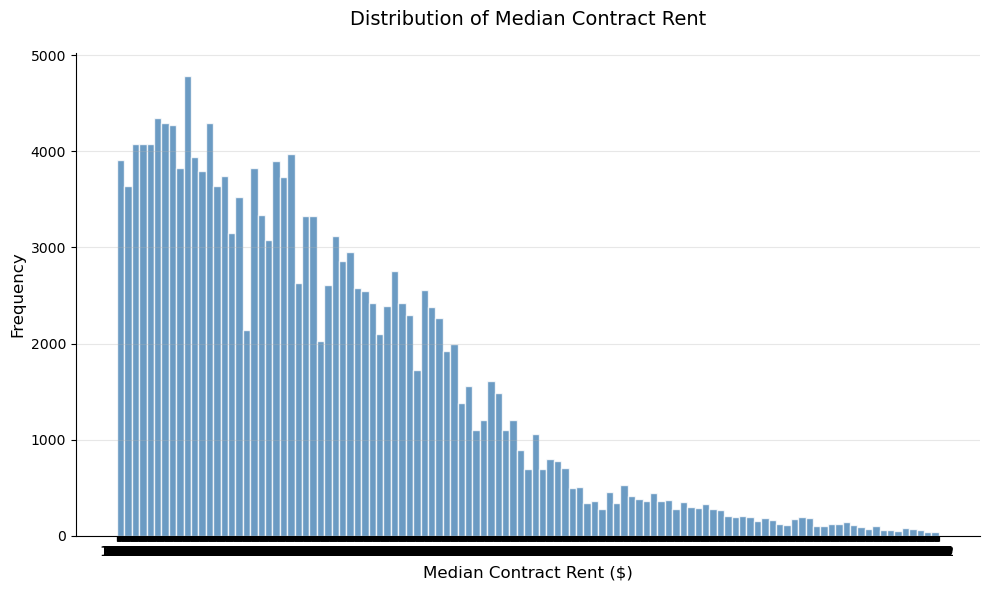

In [586]:
plt.figure(figsize=(10, 6))

# Create histogram with customized appearance
n, bins, patches = plt.hist(dfWalk['Median_Contract_Rent'], 
                           bins='auto',  # Let matplotlib choose optimal bin count
                           color='steelblue', 
                           edgecolor='white', 
                           alpha=0.8,
                           density=False)  # Set to True if you want probability density

# Add labels and title
plt.xlabel('Median Contract Rent ($)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Median Contract Rent', fontsize=14, pad=20)

# Customize grid and spines
plt.grid(axis='y', alpha=0.3)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Adjust layout and show plot
plt.tight_layout()
plt.show()

In [391]:
dfWalk['log_Median_Contract_Rent'] = np.log(dfWalk['Median_Contract_Rent'].astype('int'))
dfWalk = dfWalk.drop(['Geography', 'Median_Contract_Rent'], axis = 1)

print(dfWalk.shape)
dfWalk.head()

(174070, 21)


,realGEOID,county,Walk_Index,state,count_housing_units,percentage_work_age,percent_no_car,percent_two_car,count_low_wage_workers,count_high_wage_workers,...,TotEmp,housing_density,population_density,employent_housing_density,jobs_per_household,jobs_within_45_minutes_auto,regional_centrality,Population,percent_non_white,log_Median_Contract_Rent
0,1500000US481130078254,48113,14.000000,Texas,460.0,0.549,0.163121,0.744681,99,191,...,66,6.250422,16.332625,7.147222,0.156028,433601,0.785893,1141,0.423313,6.708084
1,1500000US481130078253,48113,8.333333,Texas,365.0,0.811,0.057751,0.507599,136,138,...,0,13.843035,27.951553,13.843035,0.000000,404573,0.733281,528,0.748106,6.606650
2,1500000US481130078242,48113,10.166667,Texas,343.0,0.506,0.014577,0.790087,91,404,...,32,2.305992,6.373413,2.521128,0.093294,335700,0.608450,1001,0.046953,7.268920
3,1500000US481130078271,48113,6.833333,Texas,556.0,0.588,0.066398,0.227364,143,206,...,3,10.969254,26.357776,11.028441,0.006036,402287,0.729137,1090,0.511927,6.717805
4,1500000US481130093012,48113,8.000000,Texas,451.0,0.644,0.029891,0.915761,117,137,...,1,2.247799,7.680394,2.252783,0.002717,263813,0.478156,1286,0.157076,6.576470


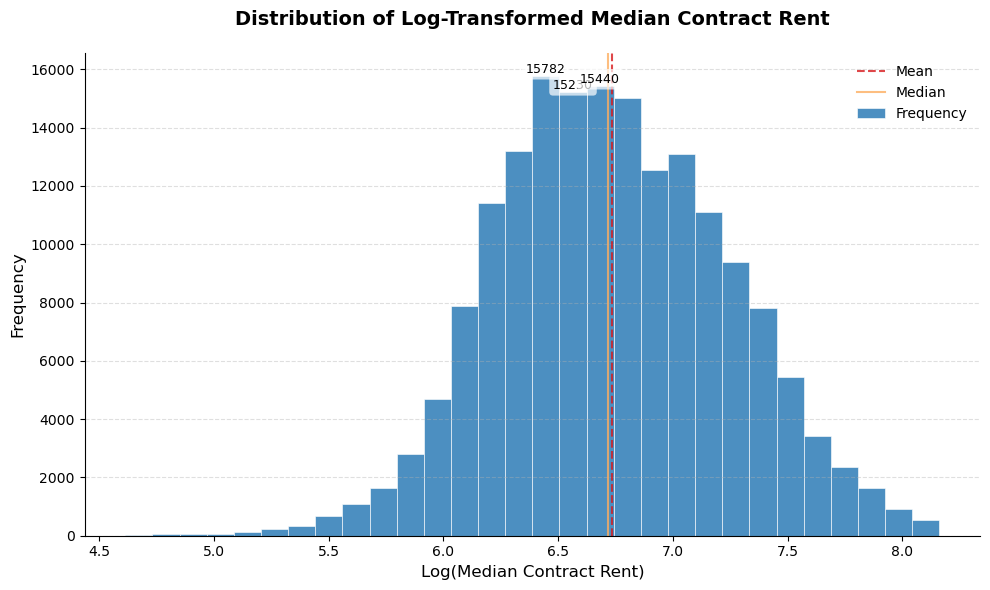

In [392]:
plt.figure(figsize=(10, 6))

# Create histogram with better aesthetics
n, bins, patches = plt.hist(dfWalk['log_Median_Contract_Rent'], 
                           bins=30,  # Explicit number of bins for log data
                           color='#2c7bb6',  # Nice blue color
                           edgecolor='white',
                           linewidth=0.5,
                           alpha=0.85)

# Add proper labels with log clarification
plt.xlabel('Log(Median Contract Rent)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Log-Transformed Median Contract Rent', 
          fontsize=14, pad=20, weight='bold')

# Customize the grid and spines
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Add mean/median indicators
mean_log = dfWalk['log_Median_Contract_Rent'].mean()
median_log = dfWalk['log_Median_Contract_Rent'].median()

plt.axvline(mean_log, color='#d7191c', linestyle='--', linewidth=1.5, alpha=0.8)
plt.axvline(median_log, color='#fdae61', linestyle='-', linewidth=1.5, alpha=0.8)

# Add legend
plt.legend(['Mean', 'Median', 'Frequency'], frameon=False)

# Add data labels to the top 3 bars (optional)
sorted_indices = np.argsort(n)[-3:]  # Get indices of top 3 tallest bars
for i in sorted_indices:
    plt.text(patches[i].get_x() + patches[i].get_width()/2, 
             patches[i].get_height()+0.5, 
             str(int(n[i])), 
             ha='center', 
             va='bottom',
             fontsize=9,
             bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', boxstyle='round'))

# Adjust layout
plt.tight_layout()
plt.show()

In [393]:
# get average household size
temp = pd.read_csv('/Users/austincoffelt/Documents/Rent-Walk-local/HH_Size_2019/HH_Size_2019.csv', header = 1)
temp = temp.rename({'Estimate!!Average household size --!!Total:!!Renter occupied': 'avg_HH_size_renters'}, axis = 1)
temp = temp[['Geography', 'avg_HH_size_renters']]

# remove observations without values
temp = temp[temp['avg_HH_size_renters'] != '-']
temp.head()

,Geography,avg_HH_size_renters
0,1500000US010010201001,1.78
1,1500000US010010201002,3.40
2,1500000US010010202001,2.42
3,1500000US010010202002,2.14
4,1500000US010010203001,2.49


In [394]:
# merge dfWalk with household data on GEOID
dfWalk = dfWalk.merge(temp, how = 'inner', left_on = 'realGEOID', right_on = 'Geography')
dfWalk = dfWalk.drop('Geography', axis = 1)
dfWalk['avg_HH_size_renters'] = dfWalk['avg_HH_size_renters'].astype('float')
print(dfWalk.shape)
dfWalk.head()

(173448, 22)


,realGEOID,county,Walk_Index,state,count_housing_units,percentage_work_age,percent_no_car,percent_two_car,count_low_wage_workers,count_high_wage_workers,...,housing_density,population_density,employent_housing_density,jobs_per_household,jobs_within_45_minutes_auto,regional_centrality,Population,percent_non_white,log_Median_Contract_Rent,avg_HH_size_renters
0,1500000US481130078254,48113,14.000000,Texas,460.0,0.549,0.163121,0.744681,99,191,...,6.250422,16.332625,7.147222,0.156028,433601,0.785893,1141,0.423313,6.708084,2.55
1,1500000US481130078253,48113,8.333333,Texas,365.0,0.811,0.057751,0.507599,136,138,...,13.843035,27.951553,13.843035,0.000000,404573,0.733281,528,0.748106,6.606650,2.05
2,1500000US481130078242,48113,10.166667,Texas,343.0,0.506,0.014577,0.790087,91,404,...,2.305992,6.373413,2.521128,0.093294,335700,0.608450,1001,0.046953,7.268920,2.16
3,1500000US481130078271,48113,6.833333,Texas,556.0,0.588,0.066398,0.227364,143,206,...,10.969254,26.357776,11.028441,0.006036,402287,0.729137,1090,0.511927,6.717805,2.72
4,1500000US481130093012,48113,8.000000,Texas,451.0,0.644,0.029891,0.915761,117,137,...,2.247799,7.680394,2.252783,0.002717,263813,0.478156,1286,0.157076,6.576470,4.81


In [395]:
# read in household heating data
temp = pd.read_csv('/Users/austincoffelt/Documents/Rent-Walk-local/heating_2019/heating_2019.csv', header = 1)

# get percentage of different heating methods
temp['percent_gas_energy'] = temp['Estimate!!Total:!!Utility gas'] / temp['Estimate!!Total:']
temp['percent_elec_energy'] = temp['Estimate!!Total:!!Electricity'] / temp['Estimate!!Total:']
temp['percent_solar_energy'] = temp['Estimate!!Total:!!Solar energy'] / temp['Estimate!!Total:']
temp['percent_no_energy'] = temp['Estimate!!Total:!!No fuel used'] / temp['Estimate!!Total:']
temp = temp[['Geography', 'percent_gas_energy', 'percent_elec_energy', 'percent_solar_energy', 'percent_no_energy']]
temp.head()

,Geography,percent_gas_energy,percent_elec_energy,percent_solar_energy,percent_no_energy
0,1500000US010010201001,0.412698,0.539683,0.0,0.0
1,1500000US010010201002,0.563452,0.423858,0.0,0.0
2,1500000US010010202001,0.600629,0.399371,0.0,0.0
3,1500000US010010202002,0.743243,0.235135,0.0,0.0
4,1500000US010010203001,0.661793,0.327485,0.0,0.0


In [396]:
# merge dfWalk with household heating data on GEOID
dfWalk = dfWalk.merge(temp, how = 'inner', left_on = 'realGEOID', right_on = 'Geography')
dfWalk = dfWalk.drop('Geography', axis = 1)
print(dfWalk.shape)
dfWalk.head()

(173448, 26)


,realGEOID,county,Walk_Index,state,count_housing_units,percentage_work_age,percent_no_car,percent_two_car,count_low_wage_workers,count_high_wage_workers,...,jobs_within_45_minutes_auto,regional_centrality,Population,percent_non_white,log_Median_Contract_Rent,avg_HH_size_renters,percent_gas_energy,percent_elec_energy,percent_solar_energy,percent_no_energy
0,1500000US481130078254,48113,14.000000,Texas,460.0,0.549,0.163121,0.744681,99,191,...,433601,0.785893,1141,0.423313,6.708084,2.55,0.229730,0.770270,0.0,0.000000
1,1500000US481130078253,48113,8.333333,Texas,365.0,0.811,0.057751,0.507599,136,138,...,404573,0.733281,528,0.748106,6.606650,2.05,0.000000,0.941860,0.0,0.000000
2,1500000US481130078242,48113,10.166667,Texas,343.0,0.506,0.014577,0.790087,91,404,...,335700,0.608450,1001,0.046953,7.268920,2.16,0.740331,0.259669,0.0,0.000000
3,1500000US481130078271,48113,6.833333,Texas,556.0,0.588,0.066398,0.227364,143,206,...,402287,0.729137,1090,0.511927,6.717805,2.72,0.018100,0.968326,0.0,0.013575
4,1500000US481130093012,48113,8.000000,Texas,451.0,0.644,0.029891,0.915761,117,137,...,263813,0.478156,1286,0.157076,6.576470,4.81,0.970760,0.029240,0.0,0.000000


In [397]:
# get internet access data and find the percent that have no internet access
temp = pd.read_csv('/Users/austincoffelt/Documents/Rent-Walk-local/Internet_2019.csv', header = 1)
temp['percent_no_internet'] = temp['Estimate!!Total:!!No Internet access'] / temp['Estimate!!Total:']
temp = temp[['Geography', 'percent_no_internet']]
temp.head()

,Geography,percent_no_internet
0,1500000US010010201001,0.298413
1,1500000US010010201002,0.197970
2,1500000US010010202001,0.393082
3,1500000US010010202002,0.227027
4,1500000US010010203001,0.119883


In [398]:
# merge dfWalk with internet access data on GEOID
dfWalk = dfWalk.merge(temp, how = 'inner', left_on = 'realGEOID', right_on = 'Geography')
dfWalk = dfWalk.drop('Geography', axis = 1)
print(dfWalk.shape)
dfWalk.head()

(173448, 27)


,realGEOID,county,Walk_Index,state,count_housing_units,percentage_work_age,percent_no_car,percent_two_car,count_low_wage_workers,count_high_wage_workers,...,regional_centrality,Population,percent_non_white,log_Median_Contract_Rent,avg_HH_size_renters,percent_gas_energy,percent_elec_energy,percent_solar_energy,percent_no_energy,percent_no_internet
0,1500000US481130078254,48113,14.000000,Texas,460.0,0.549,0.163121,0.744681,99,191,...,0.785893,1141,0.423313,6.708084,2.55,0.229730,0.770270,0.0,0.000000,0.121622
1,1500000US481130078253,48113,8.333333,Texas,365.0,0.811,0.057751,0.507599,136,138,...,0.733281,528,0.748106,6.606650,2.05,0.000000,0.941860,0.0,0.000000,0.201550
2,1500000US481130078242,48113,10.166667,Texas,343.0,0.506,0.014577,0.790087,91,404,...,0.608450,1001,0.046953,7.268920,2.16,0.740331,0.259669,0.0,0.000000,0.016575
3,1500000US481130078271,48113,6.833333,Texas,556.0,0.588,0.066398,0.227364,143,206,...,0.729137,1090,0.511927,6.717805,2.72,0.018100,0.968326,0.0,0.013575,0.126697
4,1500000US481130093012,48113,8.000000,Texas,451.0,0.644,0.029891,0.915761,117,137,...,0.478156,1286,0.157076,6.576470,4.81,0.970760,0.029240,0.0,0.000000,0.201754


In [399]:
# read in kitchen data
temp = pd.read_csv('/Users/austincoffelt/Documents/Rent-Walk-local/Kitchen_2019.csv', header = 1)

# get percentage that are lacking kitchen utilities
temp['percent_lacking_kitchen_renter'] = temp['Estimate!!Total:!!Renter occupied:!!Lacking complete kitchen facilities'] / temp['Estimate!!Total:!!Renter occupied:']
temp = temp[['Geography', 'percent_lacking_kitchen_renter']]
temp.head()

,Geography,percent_lacking_kitchen_renter
0,1500000US010010201001,0.0
1,1500000US010010201002,0.0
2,1500000US010010202001,0.0
3,1500000US010010202002,0.0
4,1500000US010010203001,0.0


In [400]:
# merge dfWalk with kitchen data on GEOID
dfWalk = dfWalk.merge(temp, how = 'inner', left_on = 'realGEOID', right_on = 'Geography')
dfWalk = dfWalk.drop('Geography', axis = 1)
print(dfWalk.shape)
dfWalk.head()

(173448, 28)


,realGEOID,county,Walk_Index,state,count_housing_units,percentage_work_age,percent_no_car,percent_two_car,count_low_wage_workers,count_high_wage_workers,...,Population,percent_non_white,log_Median_Contract_Rent,avg_HH_size_renters,percent_gas_energy,percent_elec_energy,percent_solar_energy,percent_no_energy,percent_no_internet,percent_lacking_kitchen_renter
0,1500000US481130078254,48113,14.000000,Texas,460.0,0.549,0.163121,0.744681,99,191,...,1141,0.423313,6.708084,2.55,0.229730,0.770270,0.0,0.000000,0.121622,0.0
1,1500000US481130078253,48113,8.333333,Texas,365.0,0.811,0.057751,0.507599,136,138,...,528,0.748106,6.606650,2.05,0.000000,0.941860,0.0,0.000000,0.201550,0.0
2,1500000US481130078242,48113,10.166667,Texas,343.0,0.506,0.014577,0.790087,91,404,...,1001,0.046953,7.268920,2.16,0.740331,0.259669,0.0,0.000000,0.016575,0.0
3,1500000US481130078271,48113,6.833333,Texas,556.0,0.588,0.066398,0.227364,143,206,...,1090,0.511927,6.717805,2.72,0.018100,0.968326,0.0,0.013575,0.126697,0.0
4,1500000US481130093012,48113,8.000000,Texas,451.0,0.644,0.029891,0.915761,117,137,...,1286,0.157076,6.576470,4.81,0.970760,0.029240,0.0,0.000000,0.201754,0.0


In [401]:
# read in living arrangement data
temp = pd.read_csv('/Users/austincoffelt/Documents/Rent-Walk-local/Living_Arange_2019/Living_Arange_2019.csv', header = 1)

# get percentage that live alone
temp['percent_lives_alone'] = temp['Estimate!!Total:!!Nonfamily households:!!Householder living alone'] / temp['Estimate!!Total:']
temp = temp[['Geography', 'percent_lives_alone']]
temp.head()

,Geography,percent_lives_alone
0,1500000US010010201001,0.307937
1,1500000US010010201002,0.060914
2,1500000US010010202001,0.367925
3,1500000US010010202002,0.443243
4,1500000US010010203001,0.182261


In [402]:
# merge dfWalk with living alone data on GEOID
dfWalk = dfWalk.merge(temp, how = 'inner', left_on = 'realGEOID', right_on = 'Geography')
dfWalk = dfWalk.drop('Geography', axis = 1)
print(dfWalk.shape)
dfWalk.head()

(173448, 29)


,realGEOID,county,Walk_Index,state,count_housing_units,percentage_work_age,percent_no_car,percent_two_car,count_low_wage_workers,count_high_wage_workers,...,percent_non_white,log_Median_Contract_Rent,avg_HH_size_renters,percent_gas_energy,percent_elec_energy,percent_solar_energy,percent_no_energy,percent_no_internet,percent_lacking_kitchen_renter,percent_lives_alone
0,1500000US481130078254,48113,14.000000,Texas,460.0,0.549,0.163121,0.744681,99,191,...,0.423313,6.708084,2.55,0.229730,0.770270,0.0,0.000000,0.121622,0.0,0.186937
1,1500000US481130078253,48113,8.333333,Texas,365.0,0.811,0.057751,0.507599,136,138,...,0.748106,6.606650,2.05,0.000000,0.941860,0.0,0.000000,0.201550,0.0,0.468992
2,1500000US481130078242,48113,10.166667,Texas,343.0,0.506,0.014577,0.790087,91,404,...,0.046953,7.268920,2.16,0.740331,0.259669,0.0,0.000000,0.016575,0.0,0.121547
3,1500000US481130078271,48113,6.833333,Texas,556.0,0.588,0.066398,0.227364,143,206,...,0.511927,6.717805,2.72,0.018100,0.968326,0.0,0.013575,0.126697,0.0,0.328054
4,1500000US481130093012,48113,8.000000,Texas,451.0,0.644,0.029891,0.915761,117,137,...,0.157076,6.576470,4.81,0.970760,0.029240,0.0,0.000000,0.201754,0.0,0.017544


In [403]:
# get median household income data
temp = pd.read_csv('/Users/austincoffelt/Documents/Rent-Walk-Local/Income_2019/Income_2019.csv', header = 1)
temp = temp.rename({'Estimate!!Median household income in the past 12 months (in 2019 inflation-adjusted dollars)': 'Median_Household_Income'}, axis = 1)
temp = temp[['Geography', 'Median_Household_Income']]

# remove observations without numbers
temp = temp[temp['Median_Household_Income'] != '-']
temp.head()

,Geography,Median_Household_Income
0,1500000US010010201001,35703
1,1500000US010010201002,79000
2,1500000US010010202001,26500
3,1500000US010010202002,51042
4,1500000US010010203001,59048


In [404]:
# merge dfWalk with median household income data on GEOID
dfWalk = dfWalk.merge(temp, how = 'inner', left_on = 'realGEOID', right_on = 'Geography')
dfWalk = dfWalk[dfWalk['Median_Household_Income'] != '250,000+']
dfWalk = dfWalk[dfWalk['Median_Household_Income'] != '2,500-']
dfWalk = dfWalk[dfWalk['Median_Household_Income'].isna() == False]
dfWalk['log_Median_Household_Income'] = np.log(dfWalk['Median_Household_Income'].astype('int'))
dfWalk = dfWalk.drop(['Geography','Median_Household_Income'] , axis = 1)
print(dfWalk.shape)
dfWalk.head()

(168867, 30)


,realGEOID,county,Walk_Index,state,count_housing_units,percentage_work_age,percent_no_car,percent_two_car,count_low_wage_workers,count_high_wage_workers,...,log_Median_Contract_Rent,avg_HH_size_renters,percent_gas_energy,percent_elec_energy,percent_solar_energy,percent_no_energy,percent_no_internet,percent_lacking_kitchen_renter,percent_lives_alone,log_Median_Household_Income
0,1500000US481130078254,48113,14.000000,Texas,460.0,0.549,0.163121,0.744681,99,191,...,6.708084,2.55,0.229730,0.770270,0.0,0.000000,0.121622,0.0,0.186937,10.870243
1,1500000US481130078253,48113,8.333333,Texas,365.0,0.811,0.057751,0.507599,136,138,...,6.606650,2.05,0.000000,0.941860,0.0,0.000000,0.201550,0.0,0.468992,10.415053
2,1500000US481130078242,48113,10.166667,Texas,343.0,0.506,0.014577,0.790087,91,404,...,7.268920,2.16,0.740331,0.259669,0.0,0.000000,0.016575,0.0,0.121547,11.915052
3,1500000US481130078271,48113,6.833333,Texas,556.0,0.588,0.066398,0.227364,143,206,...,6.717805,2.72,0.018100,0.968326,0.0,0.013575,0.126697,0.0,0.328054,10.400255
4,1500000US481130093012,48113,8.000000,Texas,451.0,0.644,0.029891,0.915761,117,137,...,6.576470,4.81,0.970760,0.029240,0.0,0.000000,0.201754,0.0,0.017544,10.941057


In [405]:
# get median rooms
temp = pd.read_csv('/Users/austincoffelt/Documents/Rent-Walk-Local/Rooms_2019/Rooms_2019.csv', header = 1)
temp = temp.rename({'Estimate!!Median number of rooms --!!Total:!!Renter occupied': 'Median_Num_Rooms'}, axis = 1)
temp = temp[['Geography', 'Median_Num_Rooms']]

# remove observations without numbers
temp = temp[temp['Median_Num_Rooms'] != '-']
temp.head()

,Geography,Median_Num_Rooms
0,1500000US010010201001,4.2
1,1500000US010010201002,5.3
2,1500000US010010202001,5.0
3,1500000US010010202002,5.6
4,1500000US010010203001,5.7


In [406]:
# merge dfWalk with rooms data on GEOID
dfWalk = dfWalk.merge(temp, how = 'inner', left_on = 'realGEOID', right_on = 'Geography')
dfWalk = dfWalk.drop('Geography', axis = 1)
dfWalk = dfWalk[dfWalk['Median_Num_Rooms'] != '9.0+']
dfWalk['Median_Num_Rooms'] = dfWalk['Median_Num_Rooms'].astype('float')
print(dfWalk.shape)
dfWalk.head()

(167484, 31)


,realGEOID,county,Walk_Index,state,count_housing_units,percentage_work_age,percent_no_car,percent_two_car,count_low_wage_workers,count_high_wage_workers,...,avg_HH_size_renters,percent_gas_energy,percent_elec_energy,percent_solar_energy,percent_no_energy,percent_no_internet,percent_lacking_kitchen_renter,percent_lives_alone,log_Median_Household_Income,Median_Num_Rooms
0,1500000US481130078254,48113,14.000000,Texas,460.0,0.549,0.163121,0.744681,99,191,...,2.55,0.229730,0.770270,0.0,0.000000,0.121622,0.0,0.186937,10.870243,4.0
1,1500000US481130078253,48113,8.333333,Texas,365.0,0.811,0.057751,0.507599,136,138,...,2.05,0.000000,0.941860,0.0,0.000000,0.201550,0.0,0.468992,10.415053,3.2
2,1500000US481130078242,48113,10.166667,Texas,343.0,0.506,0.014577,0.790087,91,404,...,2.16,0.740331,0.259669,0.0,0.000000,0.016575,0.0,0.121547,11.915052,2.2
3,1500000US481130078271,48113,6.833333,Texas,556.0,0.588,0.066398,0.227364,143,206,...,2.72,0.018100,0.968326,0.0,0.013575,0.126697,0.0,0.328054,10.400255,4.0
4,1500000US481130093012,48113,8.000000,Texas,451.0,0.644,0.029891,0.915761,117,137,...,4.81,0.970760,0.029240,0.0,0.000000,0.201754,0.0,0.017544,10.941057,5.3


In [407]:
# get median year built data
temp = pd.read_csv('/Users/austincoffelt/Documents/Rent-Walk-Local/Structure_2019/Structure_2019.csv', header = 1)
temp = temp.rename({'Estimate!!Median year structure built --!!Renter occupied': 'Median_Year_Structure_Built'}, axis = 1)
temp = temp[['Geography', 'Median_Year_Structure_Built']]

#remove observations without numbers
temp = temp[temp['Median_Year_Structure_Built'] != '-']
temp.head()

,Geography,Median_Year_Structure_Built
0,1500000US010010201001,1984
1,1500000US010010201002,1985
2,1500000US010010202001,1975
3,1500000US010010202002,1971
4,1500000US010010203001,1975


In [408]:
# merge dfWalk with year data on GEOID
dfWalk = dfWalk.merge(temp, how = 'inner', left_on = 'realGEOID', right_on = 'Geography')
dfWalk = dfWalk.drop('Geography', axis = 1)
dfWalk = dfWalk[dfWalk['Median_Year_Structure_Built'] != '1939-']

# for 2014+ put 2017 since that is the middle year of the data
dfWalk.loc[dfWalk['Median_Year_Structure_Built'] == '2014+', 'Median_Year_Structure_Built'] = 2017
dfWalk['Median_Year_Structure_Built'] = dfWalk['Median_Year_Structure_Built'].astype('int')
print(dfWalk.shape)
dfWalk.head()

(149393, 32)


,realGEOID,county,Walk_Index,state,count_housing_units,percentage_work_age,percent_no_car,percent_two_car,count_low_wage_workers,count_high_wage_workers,...,percent_gas_energy,percent_elec_energy,percent_solar_energy,percent_no_energy,percent_no_internet,percent_lacking_kitchen_renter,percent_lives_alone,log_Median_Household_Income,Median_Num_Rooms,Median_Year_Structure_Built
0,1500000US481130078254,48113,14.000000,Texas,460.0,0.549,0.163121,0.744681,99,191,...,0.229730,0.770270,0.0,0.000000,0.121622,0.0,0.186937,10.870243,4.0,1981
1,1500000US481130078253,48113,8.333333,Texas,365.0,0.811,0.057751,0.507599,136,138,...,0.000000,0.941860,0.0,0.000000,0.201550,0.0,0.468992,10.415053,3.2,1984
2,1500000US481130078242,48113,10.166667,Texas,343.0,0.506,0.014577,0.790087,91,404,...,0.740331,0.259669,0.0,0.000000,0.016575,0.0,0.121547,11.915052,2.2,2017
3,1500000US481130078271,48113,6.833333,Texas,556.0,0.588,0.066398,0.227364,143,206,...,0.018100,0.968326,0.0,0.013575,0.126697,0.0,0.328054,10.400255,4.0,1985
4,1500000US481130093012,48113,8.000000,Texas,451.0,0.644,0.029891,0.915761,117,137,...,0.970760,0.029240,0.0,0.000000,0.201754,0.0,0.017544,10.941057,5.3,1956


In [409]:
# get utilities facilities data
temp = pd.read_csv('/Users/austincoffelt/Documents/Rent-Walk-local/Utilities_2019.csv', header = 1)

# get percentage that have to pay extra
temp['percent_pay_extra'] = temp['Estimate!!Total:!!Pay extra for one or more utilities'] / temp['Estimate!!Total:']
temp = temp[['Geography', 'percent_pay_extra']]
temp.head()

,Geography,percent_pay_extra
0,1500000US010010201001,1.000000
1,1500000US010010201002,1.000000
2,1500000US010010202001,0.976048
3,1500000US010010202002,1.000000
4,1500000US010010203001,0.956679


In [410]:
# merge dfWalk with utilities data on GEOID
dfWalk = dfWalk.merge(temp, how = 'inner', left_on = 'realGEOID', right_on = 'Geography')
dfWalk = dfWalk.drop('Geography', axis = 1)
print(dfWalk.shape)
dfWalk.head()

(149393, 33)


,realGEOID,county,Walk_Index,state,count_housing_units,percentage_work_age,percent_no_car,percent_two_car,count_low_wage_workers,count_high_wage_workers,...,percent_elec_energy,percent_solar_energy,percent_no_energy,percent_no_internet,percent_lacking_kitchen_renter,percent_lives_alone,log_Median_Household_Income,Median_Num_Rooms,Median_Year_Structure_Built,percent_pay_extra
0,1500000US481130078254,48113,14.000000,Texas,460.0,0.549,0.163121,0.744681,99,191,...,0.770270,0.0,0.000000,0.121622,0.0,0.186937,10.870243,4.0,1981,1.000000
1,1500000US481130078253,48113,8.333333,Texas,365.0,0.811,0.057751,0.507599,136,138,...,0.941860,0.0,0.000000,0.201550,0.0,0.468992,10.415053,3.2,1984,0.612403
2,1500000US481130078242,48113,10.166667,Texas,343.0,0.506,0.014577,0.790087,91,404,...,0.259669,0.0,0.000000,0.016575,0.0,0.121547,11.915052,2.2,2017,1.000000
3,1500000US481130078271,48113,6.833333,Texas,556.0,0.588,0.066398,0.227364,143,206,...,0.968326,0.0,0.013575,0.126697,0.0,0.328054,10.400255,4.0,1985,1.000000
4,1500000US481130093012,48113,8.000000,Texas,451.0,0.644,0.029891,0.915761,117,137,...,0.029240,0.0,0.000000,0.201754,0.0,0.017544,10.941057,5.3,1956,1.000000


In [411]:
# get plumbing facilities data
temp = pd.read_csv('/Users/austincoffelt/Documents/Rent-Walk-local/Plumbing_2019.csv', header = 1)

# get percentage with lackluster facilities
temp['percent_lacking_plumbing_renter'] = temp['Estimate!!Total:!!Renter occupied:!!Lacking plumbing facilities'] / temp['Estimate!!Total:!!Renter occupied:']
temp = temp[['Geography', 'percent_lacking_plumbing_renter']]
temp.head()

,Geography,percent_lacking_plumbing_renter
0,1500000US010010201001,0.0
1,1500000US010010201002,0.0
2,1500000US010010202001,0.0
3,1500000US010010202002,0.0
4,1500000US010010203001,0.0


In [412]:
# merge dfWalk with plumbing data on GEOID
dfWalk = dfWalk.merge(temp, how = 'inner', left_on = 'realGEOID', right_on = 'Geography')
dfWalk = dfWalk.drop('Geography', axis = 1)
print(dfWalk.shape)
dfWalk.head()

(149393, 34)


,realGEOID,county,Walk_Index,state,count_housing_units,percentage_work_age,percent_no_car,percent_two_car,count_low_wage_workers,count_high_wage_workers,...,percent_solar_energy,percent_no_energy,percent_no_internet,percent_lacking_kitchen_renter,percent_lives_alone,log_Median_Household_Income,Median_Num_Rooms,Median_Year_Structure_Built,percent_pay_extra,percent_lacking_plumbing_renter
0,1500000US481130078254,48113,14.000000,Texas,460.0,0.549,0.163121,0.744681,99,191,...,0.0,0.000000,0.121622,0.0,0.186937,10.870243,4.0,1981,1.000000,0.0
1,1500000US481130078253,48113,8.333333,Texas,365.0,0.811,0.057751,0.507599,136,138,...,0.0,0.000000,0.201550,0.0,0.468992,10.415053,3.2,1984,0.612403,0.0
2,1500000US481130078242,48113,10.166667,Texas,343.0,0.506,0.014577,0.790087,91,404,...,0.0,0.000000,0.016575,0.0,0.121547,11.915052,2.2,2017,1.000000,0.0
3,1500000US481130078271,48113,6.833333,Texas,556.0,0.588,0.066398,0.227364,143,206,...,0.0,0.013575,0.126697,0.0,0.328054,10.400255,4.0,1985,1.000000,0.0
4,1500000US481130093012,48113,8.000000,Texas,451.0,0.644,0.029891,0.915761,117,137,...,0.0,0.000000,0.201754,0.0,0.017544,10.941057,5.3,1956,1.000000,0.0


In [413]:
# get commute data
temp = pd.read_csv('/Users/austincoffelt/Documents/Rent-Walk-local/Means_of_transport_2019.csv', header = 1)

# get percentage with different commutes
temp['percent_drive'] = temp['Estimate!!Total:!!Car, truck, or van:'] / temp['Estimate!!Total:']
temp['percent_public_transport'] = temp['Estimate!!Total:!!Public transportation (excluding taxicab):'] / temp['Estimate!!Total:']
temp['percent_bike'] = temp['Estimate!!Total:!!Bicycle'] / temp['Estimate!!Total:']
temp['percent_walk'] = temp['Estimate!!Total:!!Walked'] / temp['Estimate!!Total:']
temp = temp[['Geography', 'percent_drive', 'percent_public_transport', 'percent_bike', 'percent_walk']]
temp.head()

,Geography,percent_drive,percent_public_transport,percent_bike,percent_walk
0,1500000US010010201001,1.000000,0.0,0.0,0.000000
1,1500000US010010201002,0.953198,0.0,0.0,0.000000
2,1500000US010010202001,0.965779,0.0,0.0,0.000000
3,1500000US010010202002,1.000000,0.0,0.0,0.000000
4,1500000US010010203001,0.949280,0.0,0.0,0.013708


In [414]:
# merge dfWalk with commute data on GEOID
dfWalk = dfWalk.merge(temp, how = 'inner', left_on = 'realGEOID', right_on = 'Geography')
dfWalk = dfWalk.drop('Geography', axis = 1)
print(dfWalk.shape)
dfWalk.head()

(149393, 38)


,realGEOID,county,Walk_Index,state,count_housing_units,percentage_work_age,percent_no_car,percent_two_car,count_low_wage_workers,count_high_wage_workers,...,percent_lives_alone,log_Median_Household_Income,Median_Num_Rooms,Median_Year_Structure_Built,percent_pay_extra,percent_lacking_plumbing_renter,percent_drive,percent_public_transport,percent_bike,percent_walk
0,1500000US481130078254,48113,14.000000,Texas,460.0,0.549,0.163121,0.744681,99,191,...,0.186937,10.870243,4.0,1981,1.000000,0.0,0.866516,0.061086,0.0,0.072398
1,1500000US481130078253,48113,8.333333,Texas,365.0,0.811,0.057751,0.507599,136,138,...,0.468992,10.415053,3.2,1984,0.612403,0.0,0.946619,0.000000,0.0,0.053381
2,1500000US481130078242,48113,10.166667,Texas,343.0,0.506,0.014577,0.790087,91,404,...,0.121547,11.915052,2.2,2017,1.000000,0.0,0.822785,0.025316,0.0,0.014768
3,1500000US481130078271,48113,6.833333,Texas,556.0,0.588,0.066398,0.227364,143,206,...,0.328054,10.400255,4.0,1985,1.000000,0.0,0.973140,0.000000,0.0,0.012397
4,1500000US481130093012,48113,8.000000,Texas,451.0,0.644,0.029891,0.915761,117,137,...,0.017544,10.941057,5.3,1956,1.000000,0.0,0.981795,0.018205,0.0,0.000000


In [415]:
# get time of departure data
temp = pd.read_csv('/Users/austincoffelt/Documents/Rent-Walk-local/Time_of_departure_2019.csv', header = 1)

# get percentage with different commutes
temp['before_6am'] = (temp['Estimate!!Total:!!12:00 a.m. to 4:59 a.m.'] + temp['Estimate!!Total:!!5:00 a.m. to 5:29 a.m.'] + temp['Estimate!!Total:!!5:30 a.m. to 5:59 a.m.']) / temp['Estimate!!Total:']
temp = temp[['Geography', 'before_6am']]
temp.head()

,Geography,before_6am
0,1500000US010010201001,0.097720
1,1500000US010010201002,0.064935
2,1500000US010010202001,0.169291
3,1500000US010010202002,0.197872
4,1500000US010010203001,0.107789


In [416]:
# merge dfWalk with commute data on GEOID
dfWalk = dfWalk.merge(temp, how = 'inner', left_on = 'realGEOID', right_on = 'Geography')
dfWalk = dfWalk.drop('Geography', axis = 1)
print(dfWalk.shape)
dfWalk.head()

(149393, 39)


,realGEOID,county,Walk_Index,state,count_housing_units,percentage_work_age,percent_no_car,percent_two_car,count_low_wage_workers,count_high_wage_workers,...,log_Median_Household_Income,Median_Num_Rooms,Median_Year_Structure_Built,percent_pay_extra,percent_lacking_plumbing_renter,percent_drive,percent_public_transport,percent_bike,percent_walk,before_6am
0,1500000US481130078254,48113,14.000000,Texas,460.0,0.549,0.163121,0.744681,99,191,...,10.870243,4.0,1981,1.000000,0.0,0.866516,0.061086,0.0,0.072398,0.194570
1,1500000US481130078253,48113,8.333333,Texas,365.0,0.811,0.057751,0.507599,136,138,...,10.415053,3.2,1984,0.612403,0.0,0.946619,0.000000,0.0,0.053381,0.039146
2,1500000US481130078242,48113,10.166667,Texas,343.0,0.506,0.014577,0.790087,91,404,...,11.915052,2.2,2017,1.000000,0.0,0.822785,0.025316,0.0,0.014768,0.061125
3,1500000US481130078271,48113,6.833333,Texas,556.0,0.588,0.066398,0.227364,143,206,...,10.400255,4.0,1985,1.000000,0.0,0.973140,0.000000,0.0,0.012397,0.046122
4,1500000US481130093012,48113,8.000000,Texas,451.0,0.644,0.029891,0.915761,117,137,...,10.941057,5.3,1956,1.000000,0.0,0.981795,0.018205,0.0,0.000000,0.132640


In [417]:
# get travel time data
temp = pd.read_csv('/Users/austincoffelt/Documents/Rent-Walk-local/travel_time_2019.csv', header = 1)

# get percentage with different commutes
temp['less_than_15_minutes'] = (temp['Estimate!!Total:!!Less than 5 minutes'] + temp['Estimate!!Total:!!5 to 9 minutes'] + temp['Estimate!!Total:!!10 to 14 minutes']) / temp['Estimate!!Total:']
temp['more_than_1_hour'] = (temp['Estimate!!Total:!!90 or more minutes'] + temp['Estimate!!Total:!!60 to 89 minutes']) / temp['Estimate!!Total:']
temp = temp[['Geography', 'less_than_15_minutes', 'more_than_1_hour']]
temp.head()

,Geography,less_than_15_minutes,more_than_1_hour
0,1500000US010010201001,0.547231,0.000000
1,1500000US010010201002,0.318182,0.004870
2,1500000US010010202001,0.275591,0.019685
3,1500000US010010202002,0.231915,0.025532
4,1500000US010010203001,0.303199,0.042420


In [418]:
# merge dfWalk with commute data on GEOID
dfWalk = dfWalk.merge(temp, how = 'inner', left_on = 'realGEOID', right_on = 'Geography')
dfWalk = dfWalk.drop('Geography', axis = 1)
print(dfWalk.shape)
dfWalk.head()

(149393, 41)


,realGEOID,county,Walk_Index,state,count_housing_units,percentage_work_age,percent_no_car,percent_two_car,count_low_wage_workers,count_high_wage_workers,...,Median_Year_Structure_Built,percent_pay_extra,percent_lacking_plumbing_renter,percent_drive,percent_public_transport,percent_bike,percent_walk,before_6am,less_than_15_minutes,more_than_1_hour
0,1500000US481130078254,48113,14.000000,Texas,460.0,0.549,0.163121,0.744681,99,191,...,1981,1.000000,0.0,0.866516,0.061086,0.0,0.072398,0.194570,0.106335,0.332579
1,1500000US481130078253,48113,8.333333,Texas,365.0,0.811,0.057751,0.507599,136,138,...,1984,0.612403,0.0,0.946619,0.000000,0.0,0.053381,0.039146,0.117438,0.000000
2,1500000US481130078242,48113,10.166667,Texas,343.0,0.506,0.014577,0.790087,91,404,...,2017,1.000000,0.0,0.822785,0.025316,0.0,0.014768,0.061125,0.271394,0.000000
3,1500000US481130078271,48113,6.833333,Texas,556.0,0.588,0.066398,0.227364,143,206,...,1985,1.000000,0.0,0.973140,0.000000,0.0,0.012397,0.046122,0.171908,0.092243
4,1500000US481130093012,48113,8.000000,Texas,451.0,0.644,0.029891,0.915761,117,137,...,1956,1.000000,0.0,0.981795,0.018205,0.0,0.000000,0.132640,0.165150,0.081925


In [419]:
# get move in data
temp = pd.read_csv('/Users/austincoffelt/Documents/Rent-Walk-local/Move_in_2019/Move_in_2019.csv', header = 1)
temp = temp.rename({'Estimate!!Median year householder moved into unit --!!Total:!!Renter occupied': 'Median_Year_Move_in'}, axis = 1)
temp = temp[['Geography', 'Median_Year_Move_in']]

#remove observations without numbers
temp = temp[temp['Median_Year_Move_in'] != '-']
temp = temp[temp['Median_Year_Move_in'] != '1990-']
temp.loc[(temp['Median_Year_Move_in'] == '2017+'), 'Median_Year_Move_in'] = 2018
temp['Median_Year_Move_in'] = temp['Median_Year_Move_in'].astype('int')
temp.head()

,Geography,Median_Year_Move_in
0,1500000US010010201001,2014
1,1500000US010010201002,2014
2,1500000US010010202001,2011
3,1500000US010010202002,2012
4,1500000US010010203001,2012


In [420]:
# merge dfWalk with move in data on GEOID
dfWalk = dfWalk.merge(temp, how = 'inner', left_on = 'realGEOID', right_on = 'Geography')
dfWalk = dfWalk.drop('Geography', axis = 1)
print(dfWalk.shape)
dfWalk.head()

(146255, 42)


,realGEOID,county,Walk_Index,state,count_housing_units,percentage_work_age,percent_no_car,percent_two_car,count_low_wage_workers,count_high_wage_workers,...,percent_pay_extra,percent_lacking_plumbing_renter,percent_drive,percent_public_transport,percent_bike,percent_walk,before_6am,less_than_15_minutes,more_than_1_hour,Median_Year_Move_in
0,1500000US481130078254,48113,14.000000,Texas,460.0,0.549,0.163121,0.744681,99,191,...,1.000000,0.0,0.866516,0.061086,0.0,0.072398,0.194570,0.106335,0.332579,2013
1,1500000US481130078253,48113,8.333333,Texas,365.0,0.811,0.057751,0.507599,136,138,...,0.612403,0.0,0.946619,0.000000,0.0,0.053381,0.039146,0.117438,0.000000,2015
2,1500000US481130078242,48113,10.166667,Texas,343.0,0.506,0.014577,0.790087,91,404,...,1.000000,0.0,0.822785,0.025316,0.0,0.014768,0.061125,0.271394,0.000000,2018
3,1500000US481130078271,48113,6.833333,Texas,556.0,0.588,0.066398,0.227364,143,206,...,1.000000,0.0,0.973140,0.000000,0.0,0.012397,0.046122,0.171908,0.092243,2014
4,1500000US481130093012,48113,8.000000,Texas,451.0,0.644,0.029891,0.915761,117,137,...,1.000000,0.0,0.981795,0.018205,0.0,0.000000,0.132640,0.165150,0.081925,2011


In [421]:
list(dfWalk.columns)

['realGEOID',
 'county',
 'Walk_Index',
 'state',
 'count_housing_units',
 'percentage_work_age',
 'percent_no_car',
 'percent_two_car',
 'count_low_wage_workers',
 'count_high_wage_workers',
 'percent_low_wage_workers',
 'TotEmp',
 'housing_density',
 'population_density',
 'employent_housing_density',
 'jobs_per_household',
 'jobs_within_45_minutes_auto',
 'regional_centrality',
 'Population',
 'percent_non_white',
 'log_Median_Contract_Rent',
 'avg_HH_size_renters',
 'percent_gas_energy',
 'percent_elec_energy',
 'percent_solar_energy',
 'percent_no_energy',
 'percent_no_internet',
 'percent_lacking_kitchen_renter',
 'percent_lives_alone',
 'log_Median_Household_Income',
 'Median_Num_Rooms',
 'Median_Year_Structure_Built',
 'percent_pay_extra',
 'percent_lacking_plumbing_renter',
 'percent_drive',
 'percent_public_transport',
 'percent_bike',
 'percent_walk',
 'before_6am',
 'less_than_15_minutes',
 'more_than_1_hour',
 'Median_Year_Move_in']

In [422]:
# separate into X and Y
dfWalk = dfWalk.dropna()
y = dfWalk['log_Median_Contract_Rent']
X = dfWalk.drop(['county', 'log_Median_Contract_Rent', 'Population', 'state', 'realGEOID'], axis = 1)

# Standardize features 
scaler = StandardScaler()
X_scaled = X.copy()
X_scaled = scaler.fit_transform(X)

X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
X_scaled.head()

,Walk_Index,count_housing_units,percentage_work_age,percent_no_car,percent_two_car,count_low_wage_workers,count_high_wage_workers,percent_low_wage_workers,TotEmp,housing_density,...,percent_pay_extra,percent_lacking_plumbing_renter,percent_drive,percent_public_transport,percent_bike,percent_walk,before_6am,less_than_15_minutes,more_than_1_hour,Median_Year_Move_in
0,0.990707,-0.554996,-0.577276,0.573820,0.942852,-0.630078,-0.420200,0.020348,-0.303321,0.158313,...,0.570197,-0.187836,0.027505,0.155121,-0.281897,0.789506,0.505759,-1.007085,2.780281,-0.249505
1,-0.340367,-0.787309,2.360603,-0.280570,-0.255816,-0.246180,-0.632937,0.939894,-0.334041,0.756261,...,-1.970617,-0.187836,0.569907,-0.419931,-0.281897,0.456822,-1.080325,-0.943503,-0.990139,0.487408
2,0.090274,-0.841108,-1.059447,-0.630642,1.172424,-0.713083,0.434764,-1.409829,-0.319146,-0.152327,...,0.570197,-0.187836,-0.268611,-0.181606,-0.281897,-0.218658,-0.856034,-0.061863,-0.990139,1.592777
3,-0.692711,-0.320239,-0.139958,-0.210451,-1.672659,-0.173551,-0.359991,0.084628,-0.332645,0.529940,...,0.570197,-0.187836,0.749490,-0.419931,-0.281897,-0.260140,-1.009139,-0.631577,0.055614,0.118952
4,-0.418666,-0.577005,0.487986,-0.506468,1.807818,-0.443317,-0.636951,0.071138,-0.333575,-0.156910,...,0.570197,-0.187836,0.808089,-0.248548,-0.281897,-0.477004,-0.126232,-0.670278,-0.061367,-0.986418


In [423]:
# use lasso to find best variables to use
lassoParam = {'alpha':np.logspace(-4, 2, 200)}
lasso = GridSearchCV(Lasso(), lassoParam, cv = RepeatedKFold(n_splits = 5, n_repeats = 3, random_state = 1), scoring = ('r2', 'neg_mean_squared_error'), refit = 'neg_mean_squared_error', n_jobs = -1)
lasso.fit(X_scaled, y)

# Get the best model (refitted on full data)
best_lasso = lasso.best_estimator_

# Extract coefficients and select non-zero features
coef = pd.Series(best_lasso.coef_, index=X.columns)
selected_features = coef[np.abs(coef) >= 0.01].index.tolist()

print("Selected features:", selected_features)
print("Features eliminated:", set(X.columns) - set(selected_features))

Selected features: ['Walk_Index', 'percent_no_car', 'percent_two_car', 'count_low_wage_workers', 'count_high_wage_workers', 'percent_low_wage_workers', 'housing_density', 'population_density', 'jobs_within_45_minutes_auto', 'regional_centrality', 'percent_non_white', 'avg_HH_size_renters', 'percent_gas_energy', 'percent_elec_energy', 'percent_solar_energy', 'percent_no_energy', 'percent_no_internet', 'percent_lacking_kitchen_renter', 'percent_lives_alone', 'log_Median_Household_Income', 'Median_Num_Rooms', 'Median_Year_Structure_Built', 'percent_pay_extra', 'percent_drive', 'percent_public_transport', 'percent_walk', 'before_6am', 'less_than_15_minutes', 'more_than_1_hour', 'Median_Year_Move_in']
Features eliminated: {'jobs_per_household', 'percentage_work_age', 'percent_lacking_plumbing_renter', 'employent_housing_density', 'TotEmp', 'count_housing_units', 'percent_bike'}


In [424]:
X = dfWalk[selected_features]
print(X.shape)
X.head()

(146247, 30)


,Walk_Index,percent_no_car,percent_two_car,count_low_wage_workers,count_high_wage_workers,percent_low_wage_workers,housing_density,population_density,jobs_within_45_minutes_auto,regional_centrality,...,Median_Num_Rooms,Median_Year_Structure_Built,percent_pay_extra,percent_drive,percent_public_transport,percent_walk,before_6am,less_than_15_minutes,more_than_1_hour,Median_Year_Move_in
0,14.000000,0.163121,0.744681,99,191,0.240291,6.250422,16.332625,433601,0.785893,...,4.0,1981,1.000000,0.866516,0.061086,0.072398,0.194570,0.106335,0.332579,2013
1,8.333333,0.057751,0.507599,136,138,0.293737,13.843035,27.951553,404573,0.733281,...,3.2,1984,0.612403,0.946619,0.000000,0.053381,0.039146,0.117438,0.000000,2015
2,10.166667,0.014577,0.790087,91,404,0.157168,2.305992,6.373413,335700,0.608450,...,2.2,2017,1.000000,0.822785,0.025316,0.014768,0.061125,0.271394,0.000000,2018
3,6.833333,0.066398,0.227364,143,206,0.244027,10.969254,26.357776,402287,0.729137,...,4.0,1985,1.000000,0.973140,0.000000,0.012397,0.046122,0.171908,0.092243,2014
4,8.000000,0.029891,0.915761,117,137,0.243243,2.247799,7.680394,263813,0.478156,...,5.3,1956,1.000000,0.981795,0.018205,0.000000,0.132640,0.165150,0.081925,2011


In [425]:
X.cov()

,Walk_Index,percent_no_car,percent_two_car,count_low_wage_workers,count_high_wage_workers,percent_low_wage_workers,housing_density,population_density,jobs_within_45_minutes_auto,regional_centrality,...,Median_Num_Rooms,Median_Year_Structure_Built,percent_pay_extra,percent_drive,percent_public_transport,percent_walk,before_6am,less_than_15_minutes,more_than_1_hour,Median_Year_Move_in
Walk_Index,18.123990,0.155606,-0.338875,-3.538944,3.266676e+01,-0.006063,12.840323,2.899758e+01,2.967131e+05,0.544371,...,-1.325811,-15.140124,-0.046199,-0.222366,0.158216,0.043998,-0.079066,-0.063266,0.021413,0.325226
percent_no_car,0.155606,0.015210,-0.017191,-1.398846,-5.493958e+00,0.001145,0.664876,1.368305e+00,7.682982e+03,0.007667,...,-0.042923,-0.432087,-0.005496,-0.011005,0.008168,0.002611,-0.000827,-0.000935,0.001765,-0.046845
percent_two_car,-0.338875,-0.017191,0.039120,2.955760,1.240518e+01,-0.002184,-0.845807,-1.622372e+00,-1.004177e+04,-0.018352,...,0.094679,0.634669,0.005738,0.013312,-0.009750,-0.003512,0.002362,-0.001543,-0.000721,0.008043
count_low_wage_workers,-3.538944,-1.398846,2.955760,9289.114686,1.812061e+04,0.389151,-49.343426,-4.617501e+01,-2.519220e+05,0.332995,...,4.790875,492.601916,0.961052,1.421015,-0.687191,-0.561898,-0.132355,-2.091563,0.028499,21.856186
count_high_wage_workers,32.666762,-5.493958,12.405176,18120.609279,6.206784e+04,-5.517496,99.015457,1.595270e+02,3.250783e+06,-3.612998,...,11.649909,1370.909627,2.243866,-0.314931,0.267625,-1.106649,-3.093065,-9.742198,1.573452,61.682257
percent_low_wage_workers,-0.006063,0.001145,-0.002184,0.389151,-5.517496e+00,0.003378,-0.074162,-1.215079e-01,-1.286450e+03,0.002503,...,0.000545,-0.129533,-0.000562,0.000514,-0.000442,0.000202,0.000523,0.002632,-0.000658,0.002358
housing_density,12.840323,0.664876,-0.845807,-49.343426,9.901546e+01,-0.074162,161.234306,2.918756e+02,8.351664e+05,0.528691,...,-2.605948,-25.210985,-0.172419,-0.870801,0.651003,0.166289,-0.139227,-0.309042,0.150047,-3.234285
population_density,28.997582,1.368305,-1.622372,-46.175014,1.595270e+02,-0.121508,291.875556,6.108190e+02,1.900123e+06,1.134540,...,-4.731689,-60.558802,-0.327869,-1.825049,1.446841,0.312139,-0.230465,-0.748544,0.415098,-8.936953
jobs_within_45_minutes_auto,296713.145037,7682.981504,-10041.770266,-251922.012195,3.250783e+06,-1286.450274,835166.402584,1.900123e+06,2.095609e+10,11508.144197,...,-33592.614698,-493568.721131,-1424.504615,-11781.658346,10207.789154,1308.450809,-2180.272386,-8629.693306,3897.745577,-65636.573243
regional_centrality,0.544371,0.007667,-0.018352,0.332995,-3.612998e+00,0.002503,0.528691,1.134540e+00,1.150814e+04,0.079197,...,-0.054492,-0.692738,-0.001883,-0.006041,0.004973,0.001590,-0.005159,0.004966,-0.005203,0.070804


In [426]:
cov = pd.DataFrame(X.cov().loc[:, 'Walk_Index'])
cov = cov[np.abs(cov['Walk_Index']) >= 0.02]
cov.index.to_list()

['Walk_Index',
 'percent_no_car',
 'percent_two_car',
 'count_low_wage_workers',
 'count_high_wage_workers',
 'housing_density',
 'population_density',
 'jobs_within_45_minutes_auto',
 'regional_centrality',
 'percent_non_white',
 'avg_HH_size_renters',
 'percent_gas_energy',
 'percent_elec_energy',
 'percent_no_internet',
 'percent_lives_alone',
 'log_Median_Household_Income',
 'Median_Num_Rooms',
 'Median_Year_Structure_Built',
 'percent_pay_extra',
 'percent_drive',
 'percent_public_transport',
 'percent_walk',
 'before_6am',
 'less_than_15_minutes',
 'more_than_1_hour',
 'Median_Year_Move_in']

In [427]:
X = X[cov.index.to_list()]
print(X.shape)
X.head()

(146247, 26)


,Walk_Index,percent_no_car,percent_two_car,count_low_wage_workers,count_high_wage_workers,housing_density,population_density,jobs_within_45_minutes_auto,regional_centrality,percent_non_white,...,Median_Num_Rooms,Median_Year_Structure_Built,percent_pay_extra,percent_drive,percent_public_transport,percent_walk,before_6am,less_than_15_minutes,more_than_1_hour,Median_Year_Move_in
0,14.000000,0.163121,0.744681,99,191,6.250422,16.332625,433601,0.785893,0.423313,...,4.0,1981,1.000000,0.866516,0.061086,0.072398,0.194570,0.106335,0.332579,2013
1,8.333333,0.057751,0.507599,136,138,13.843035,27.951553,404573,0.733281,0.748106,...,3.2,1984,0.612403,0.946619,0.000000,0.053381,0.039146,0.117438,0.000000,2015
2,10.166667,0.014577,0.790087,91,404,2.305992,6.373413,335700,0.608450,0.046953,...,2.2,2017,1.000000,0.822785,0.025316,0.014768,0.061125,0.271394,0.000000,2018
3,6.833333,0.066398,0.227364,143,206,10.969254,26.357776,402287,0.729137,0.511927,...,4.0,1985,1.000000,0.973140,0.000000,0.012397,0.046122,0.171908,0.092243,2014
4,8.000000,0.029891,0.915761,117,137,2.247799,7.680394,263813,0.478156,0.157076,...,5.3,1956,1.000000,0.981795,0.018205,0.000000,0.132640,0.165150,0.081925,2011


In [428]:
X.describe()

,Walk_Index,percent_no_car,percent_two_car,count_low_wage_workers,count_high_wage_workers,housing_density,population_density,jobs_within_45_minutes_auto,regional_centrality,percent_non_white,...,Median_Num_Rooms,Median_Year_Structure_Built,percent_pay_extra,percent_drive,percent_public_transport,percent_walk,before_6am,less_than_15_minutes,more_than_1_hour,Median_Year_Move_in
count,146247.000000,146247.000000,146247.000000,146247.000000,146247.000000,146247.000000,146247.000000,1.462470e+05,146247.000000,146247.000000,...,146247.000000,146247.000000,146247.000000,146247.000000,146247.000000,146247.000000,146247.000000,146247.000000,146247.000000,146247.000000
mean,9.782350,0.092353,0.558196,159.726750,295.685717,4.240205,9.701953,9.678706e+04,0.442313,0.282629,...,4.596321,1974.969743,0.913017,0.862454,0.044608,0.027267,0.145010,0.282196,0.087338,2013.677163
std,4.257228,0.123328,0.197789,96.380053,249.134172,12.697807,24.714753,1.447622e+05,0.281419,0.263729,...,1.033752,16.248293,0.152549,0.147683,0.106227,0.057164,0.097993,0.174625,0.088208,2.714034
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,...,1.300000,1940.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1990.000000
25%,6.166667,0.017199,0.430680,100.000000,143.000000,0.367713,0.843924,9.244000e+03,0.205084,0.070959,...,3.900000,1963.000000,0.885417,0.830213,0.000000,0.000000,0.072100,0.154093,0.024138,2013.000000
50%,9.500000,0.050542,0.583429,140.000000,235.000000,1.987740,4.543499,4.025200e+04,0.456815,0.196112,...,4.500000,1975.000000,1.000000,0.904277,0.000000,0.002299,0.130435,0.247300,0.063107,2014.000000
75%,13.333333,0.118421,0.708545,197.000000,376.000000,4.246139,10.289565,1.185295e+05,0.670400,0.423180,...,5.200000,1986.000000,1.000000,0.951178,0.037705,0.031429,0.200883,0.377616,0.123967,2015.000000
max,20.000000,1.000000,1.000000,3639.000000,10683.000000,1212.245773,2725.803031,1.220602e+06,1.000000,1.000000,...,8.500000,2017.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2018.000000


In [429]:
mod = sm.OLS(y, X, axis = 1)
res = mod.fit()
robust_results = res.get_robustcov_results(cov_type='HC1')
robust_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    OLS Regression Results                                   
=============================================================================================
Dep. Variable:     log_Median_Contract_Rent   R-squared (uncentered):                   0.998
Model:                                  OLS   Adj. R-squared (uncentered):              0.998
Method:                       Least Squares   F-statistic:                          3.357e+06
Date:                      Wed, 30 Apr 2025   Prob (F-statistic):                        0.00
Time:                              12:00:45   Log-Likelihood:                         -27228.
No. Observations:                    146247   AIC:                                  5.451e+04
Df Residuals:                        146221   BIC:                                  5.477e+04
Df Model:                                26                                                  
Covariance Type:                        HC1                                                  
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Walk_Index                      0.0283      0.000    112.711      0.000       0.028       0.029
percent_no_car                 -0.3309      0.014    -23.175      0.000      -0.359      -0.303
percent_two_car                -0.2264      0.008    -27.367      0.000      -0.243      -0.210
count_low_wage_workers         -0.0004   1.62e-05    -25.204      0.000      -0.000      -0.000
count_high_wage_workers         0.0003   1.02e-05     28.326      0.000       0.000       0.000
housing_density                -0.0012      0.000     -3.393      0.001      -0.002      -0.001
population_density              0.0017      0.000      5.311      0.000       0.001       0.002
jobs_within_45_minutes_auto  3.576e-07   1.21e-08     29.649      0.000    3.34e-07    3.81e-07
regional_centrality             0.0421      0.003     12.191      0.000       0.035       0.049
percent_non_white               0.1363      0.004     34.750      0.000       0.129       0.144
avg_HH_size_renters             0.0850      0.001     60.127      0.000       0.082       0.088
percent_gas_energy              0.0479      0.005     10.071      0.000       0.039       0.057
percent_elec_energy             0.0454      0.005      9.069      0.000       0.036       0.055
percent_no_internet            -0.7190      0.010    -73.469      0.000      -0.738      -0.700
percent_lives_alone             0.2185      0.010     21.696      0.000       0.199       0.238
log_Median_Household_Income     0.4456      0.004    121.768      0.000       0.438       0.453
Median_Num_Rooms                0.0233      0.001     22.125      0.000       0.021       0.025
Median_Year_Structure_Built     0.0030   6.24e-05     47.770      0.000       0.003       0.003
percent_pay_extra              -0.1367      0.008    -18.056      0.000      -0.152      -0.122
percent_drive                  -0.5595      0.015    -38.461      0.000      -0.588      -0.531
percent_public_transport       -0.7135      0.022    -31.850      0.000      -0.757      -0.670
percent_walk                   -0.2725      0.024    -11.264      0.000      -0.320      -0.225
before_6am                     -0.1913      0.009    -20.980      0.000      -0.209      -0.173
less_than_15_minutes           -0.2403      0.006    -41.430      0.000      -0.252      -0.229
more_than_1_hour                0.3609      0.011     31.694      0.000       0.339       0.383
Median_Year_Move_in            -0.0019   6.64e-05    -28.947      0.000      -0.002      -0.002
==============================================================================
Omnibus:                     5714.996   Durbin-Watson: 

In [430]:
# get dummies for the states
stateDummies = pd.get_dummies(dfWalk.loc[:, 'state'] , drop_first = False, dtype = 'int')

# concatinate with our dataframe
XReducedStateDummies = pd.concat([X, stateDummies], axis = 1)

# drop state and california for multicoliniarity issues
XReducedStateDummies = XReducedStateDummies.drop('California' , axis = 1)

#add intercept
XReducedStateDummies['Intercept'] = 1

XReducedStateDummies.head()

,Walk_Index,percent_no_car,percent_two_car,count_low_wage_workers,count_high_wage_workers,housing_density,population_density,jobs_within_45_minutes_auto,regional_centrality,percent_non_white,...,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming,Intercept
0,14.000000,0.163121,0.744681,99,191,6.250422,16.332625,433601,0.785893,0.423313,...,0,1,0,0,0,0,0,0,0,1
1,8.333333,0.057751,0.507599,136,138,13.843035,27.951553,404573,0.733281,0.748106,...,0,1,0,0,0,0,0,0,0,1
2,10.166667,0.014577,0.790087,91,404,2.305992,6.373413,335700,0.608450,0.046953,...,0,1,0,0,0,0,0,0,0,1
3,6.833333,0.066398,0.227364,143,206,10.969254,26.357776,402287,0.729137,0.511927,...,0,1,0,0,0,0,0,0,0,1
4,8.000000,0.029891,0.915761,117,137,2.247799,7.680394,263813,0.478156,0.157076,...,0,1,0,0,0,0,0,0,0,1


In [431]:
mod = sm.OLS(y, XReducedStateDummies, axis = 1)
res = mod.fit()
robust_results = res.get_robustcov_results(cov_type='HC1')
robust_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                               
====================================================================================
Dep. Variable:     log_Median_Contract_Rent   R-squared:                       0.744
Model:                                  OLS   Adj. R-squared:                  0.743
Method:                       Least Squares   F-statistic:                     5425.
Date:                      Wed, 30 Apr 2025   Prob (F-statistic):               0.00
Time:                              12:00:46   Log-Likelihood:                -6917.8
No. Observations:                    146247   AIC:                         1.399e+04
Df Residuals:                        146169   BIC:                         1.476e+04
Df Model:                                77                                         
Covariance Type:                        HC1                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Walk_Index                      0.0138      0.000     56.892      0.000       0.013       0.014
percent_no_car                 -0.3184      0.012    -26.302      0.000      -0.342      -0.295
percent_two_car                -0.1380      0.008    -18.290      0.000      -0.153      -0.123
count_low_wage_workers         -0.0003   1.45e-05    -23.364      0.000      -0.000      -0.000
count_high_wage_workers         0.0003    8.9e-06     28.171      0.000       0.000       0.000
housing_density                -0.0002      0.000     -0.854      0.393      -0.001       0.000
population_density              0.0008      0.000      4.279      0.000       0.000       0.001
jobs_within_45_minutes_auto  5.018e-07   9.66e-09     51.972      0.000    4.83e-07    5.21e-07
regional_centrality             0.0726      0.003     23.426      0.000       0.067       0.079
percent_non_white               0.0586      0.004     15.860      0.000       0.051       0.066
avg_HH_size_renters             0.0443      0.001     36.722      0.000       0.042       0.047
percent_gas_energy              0.2305      0.005     44.031      0.000       0.220       0.241
percent_elec_energy             0.2033      0.007     31.231      0.000       0.191       0.216
percent_no_internet            -0.5103      0.009    -59.110      0.000      -0.527      -0.493
percent_lives_alone             0.2769      0.009     32.330      0.000       0.260       0.294
log_Median_Household_Income     0.3730      0.003    109.901      0.000       0.366       0.380
Median_Num_Rooms                0.0621      0.001     64.371      0.000       0.060       0.064
Median_Year_Structure_Built     0.0033   5.73e-05     57.161      0.000       0.003       0.003
percent_pay_extra              -0.1197      0.007    -16.919      0.000      -0.134      -0.106
percent_drive                  -0.2995      0.013    -23.189      0.000      -0.325      -0.274
percent_public_transport       -0.2528      0.019    -13.507      0.000      -0.289      -0.216
percent_walk                   -0.0523      0.022     -2.419      0.016      -0.095      -0.010
before_6am                     -0.2196      0.008    -26.359      0.000      -0.236      -0.203
less_than_15_minutes           -0.1900      0.005    -36.316      0.000      -0.200      -0.180
more_than_1_hour                0.1118      0.010     11.037      0.000       0.092       0.132
Median_Year_Move_in             0.0176      0.000     53.568      0.000       0.017       0.018
72                             -0.1910      0.010    -19.912      0.000      -0.210      -0.172
Alabama                        -0.5700      0.006    -88.695      0.000      -0.583      -0.557
Alaska                         -0.1141   

In [432]:
# get dummies for the counties
countyDummies = pd.get_dummies(dfWalk.loc[:, 'county'] , drop_first = False, dtype = 'int')

# concatinate with our dataframe
XReducedDummies = pd.concat([X, countyDummies], axis = 1)

# drop state and california for multicoliniarity issues
XReducedDummies = XReducedDummies.drop('42091' , axis = 1)

#add intercept
XReducedDummies['Intercept'] = 1

XReducedDummies.head()

,Walk_Index,percent_no_car,percent_two_car,count_low_wage_workers,count_high_wage_workers,housing_density,population_density,jobs_within_45_minutes_auto,regional_centrality,percent_non_white,...,72137,72139,72141,72143,72145,72147,72149,72151,72153,Intercept
0,14.000000,0.163121,0.744681,99,191,6.250422,16.332625,433601,0.785893,0.423313,...,0,0,0,0,0,0,0,0,0,1
1,8.333333,0.057751,0.507599,136,138,13.843035,27.951553,404573,0.733281,0.748106,...,0,0,0,0,0,0,0,0,0,1
2,10.166667,0.014577,0.790087,91,404,2.305992,6.373413,335700,0.608450,0.046953,...,0,0,0,0,0,0,0,0,0,1
3,6.833333,0.066398,0.227364,143,206,10.969254,26.357776,402287,0.729137,0.511927,...,0,0,0,0,0,0,0,0,0,1
4,8.000000,0.029891,0.915761,117,137,2.247799,7.680394,263813,0.478156,0.157076,...,0,0,0,0,0,0,0,0,0,1


In [433]:
mod = sm.OLS(y, XReducedDummies, axis = 1)
res = mod.fit()
robust_results = res.get_robustcov_results(cov_type='HC1')
robust_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                               
====================================================================================
Dep. Variable:     log_Median_Contract_Rent   R-squared:                       0.809
Model:                                  OLS   Adj. R-squared:                  0.805
Method:                       Least Squares   F-statistic:                 3.613e+04
Date:                      Wed, 30 Apr 2025   Prob (F-statistic):               0.00
Time:                              12:02:21   Log-Likelihood:                 14794.
No. Observations:                    146247   AIC:                        -2.311e+04
Df Residuals:                        143008   BIC:                             8933.
Df Model:                              3238                                         
Covariance Type:                        HC1                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Walk_Index                      0.0027      0.000     11.036      0.000       0.002       0.003
percent_no_car                 -0.2869      0.011    -25.391      0.000      -0.309      -0.265
percent_two_car                -0.0737      0.007    -10.711      0.000      -0.087      -0.060
count_low_wage_workers         -0.0003   1.34e-05    -21.194      0.000      -0.000      -0.000
count_high_wage_workers         0.0002   6.73e-06     24.941      0.000       0.000       0.000
housing_density                 0.0010      0.000      2.998      0.003       0.000       0.002
population_density          -2.088e-05      0.000     -0.126      0.900      -0.000       0.000
jobs_within_45_minutes_auto -6.311e-08    1.7e-08     -3.713      0.000   -9.64e-08   -2.98e-08
regional_centrality             0.1760      0.005     35.201      0.000       0.166       0.186
percent_non_white              -0.0550      0.004    -14.484      0.000      -0.062      -0.048
avg_HH_size_renters             0.0241      0.001     22.537      0.000       0.022       0.026
percent_gas_energy              0.1719      0.005     31.677      0.000       0.161       0.183
percent_elec_energy             0.1852      0.007     27.239      0.000       0.172       0.199
percent_no_internet            -0.3526      0.008    -44.533      0.000      -0.368      -0.337
percent_lives_alone             0.2024      0.008     25.781      0.000       0.187       0.218
log_Median_Household_Income     0.2824      0.003     90.076      0.000       0.276       0.289
Median_Num_Rooms                0.0773      0.001     85.749      0.000       0.076       0.079
Median_Year_Structure_Built     0.0033    5.3e-05     61.524      0.000       0.003       0.003
percent_pay_extra              -0.0712      0.007    -10.445      0.000      -0.085      -0.058
percent_drive                  -0.1915      0.012    -16.318      0.000      -0.214      -0.168
percent_public_transport       -0.1412      0.018     -7.752      0.000      -0.177      -0.106
percent_walk                    0.0216      0.020      1.091      0.275      -0.017       0.060
before_6am                     -0.1203      0.008    -15.503      0.000      -0.135      -0.105
less_than_15_minutes            0.0215      0.006      3.899      0.000       0.011       0.032
more_than_1_hour               -0.0523      0.010     -5.054      0.000      -0.073      -0.032
Median_Year_Move_in             0.0187      0.000     61.857      0.000       0.018       0.019
01001                          -0.5478      0.057     -9.586      0.000      -0.660      -0.436
01003                          -0.4345      0.033    -13.302      0.000      -0.499      -0.370
01005                          -0.8147   

In [434]:
crimeRates = pd.read_excel('/Users/austincoffelt/Documents/Rent-Walk-Local/table-6.xls', header = 3)
crimeRates['all_crime_rate'] = crimeRates.loc[crimeRates['Counties/principal cities'] == 'Rate per 100,000 inhabitants', 'Violent\ncrime'] + crimeRates.loc[crimeRates['Counties/principal cities'] == 'Rate per 100,000 inhabitants', 'Property\ncrime']
crimeRates.head()

,Metropolitan Statistical Area,Counties/principal cities,Population,Violent\ncrime,Murder and\nnonnegligent\nmanslaughter,Rape1,Robbery,Aggravated\nassault,Property\ncrime,Burglary,Larceny-\ntheft,Motor\nvehicle\ntheft,all_crime_rate
0,"Abilene, TX M.S.A.",NaN,171125,,NaN,NaN,NaN,NaN,,NaN,NaN,NaN,NaN
1,NaN,"Includes Callahan, Jones, and Taylor Counties",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,City of Abilene,123665,458,6,87.0,68.0,297,3112,576.0,2330.0,206.0,NaN
3,NaN,Total area actually reporting,1,543,6,105.0,72.0,360,3603,765.0,2596.0,242.0,NaN
4,NaN,"Rate per 100,000 inhabitants",NaN,317.3,3.5,61.4,42.1,210.4,2105.5,447.0,1517.0,141.4,2422.8


In [435]:
violent_crime_rates = crimeRates.loc[crimeRates['Counties/principal cities'] == 'Rate per 100,000 inhabitants', 'Violent\ncrime']
violent_crime_rates = violent_crime_rates.dropna()

property_crime_rates = crimeRates.loc[crimeRates['Counties/principal cities'] == 'Rate per 100,000 inhabitants', 'Property\ncrime']
property_crime_rates = property_crime_rates.dropna()

all_crime_rates = crimeRates.loc[crimeRates['Counties/principal cities'] == 'Rate per 100,000 inhabitants', 'all_crime_rate']
all_crime_rates = all_crime_rates.dropna()

mv_crime_rates = crimeRates.loc[crimeRates['Counties/principal cities'] == 'Rate per 100,000 inhabitants', 'Motor\nvehicle\ntheft']
mv_crime_rates = mv_crime_rates.dropna()

In [436]:
violentCrimeQuantile = np.quantile(violent_crime_rates, [0, 0.25, 0.5, 0.75, 1])
propertyCrimeQuantile = np.quantile(property_crime_rates, [0, 0.25, 0.5, 0.75, 1])
allCrimeQuantile = np.quantile(all_crime_rates, [0, 0.25, 0.5, 0.75, 1])
mvCrimeQuantile = np.quantile(mv_crime_rates, [0, 0.25, 0.5, 0.75, 1])

print('Violent Crimes: ' + str(violentCrimeQuantile[0]) + ', ' + str(violentCrimeQuantile[1]) + ', ' + str(violentCrimeQuantile[2]) + ', ' + str(violentCrimeQuantile[3]) + ', ' + str(violentCrimeQuantile[4]))
print('Property Crimes: ' + str(propertyCrimeQuantile[0]) + ', ' + str(propertyCrimeQuantile[1]) + ', ' + str(propertyCrimeQuantile[2]) + ', ' + str(propertyCrimeQuantile[3]) + ', ' + str(propertyCrimeQuantile[4]))
print('Violent and Property Crimes: ' + str(allCrimeQuantile[0]) + ', ' + str(allCrimeQuantile[1]) + ', ' + str(allCrimeQuantile[2]) + ', ' + str(allCrimeQuantile[3]) + ', ' + str(allCrimeQuantile[4]))
print('Motor Vehicle Thefts: ' + str(mvCrimeQuantile[0]) + ', ' + str(mvCrimeQuantile[1]) + ', ' + str(mvCrimeQuantile[2]) + ', ' + str(mvCrimeQuantile[3]) + ', ' + str(mvCrimeQuantile[4]))

Violent Crimes: 44.3, 222.3, 326.8, 453.4, 1194.6
Property Crimes: 311.1, 1560.2, 2124.2, 2639.7, 4538.7
Violent and Property Crimes: 415.0, 1818.85, 2437.5, 3020.3999999999996, 5513.6
Motor Vehicle Thefts: 14.8, 94.3, 162.75, 254.54999999999998, 674.0


In [437]:
# get all crime data
acCrime = pd.read_csv('RW Data/Alameda_County_All_Crime_BG.csv')
auCrime = pd.read_csv('RW Data/AustinTX_all_crime_by_BG.csv')
btnCrime = pd.read_csv('RW Data/Boston_All_Crime_BG.csv')
buffCrime = pd.read_csv('RW Data/Buffalo_All_Crime_BG.csv')
camCrime = pd.read_csv('RW Data/Cambridge_All_Crime_BG.csv')
chattCrime = pd.read_csv('RW Data/Chatta_All_Crime_BG.csv')
chiCrime = pd.read_csv('RW Data/Chicago_All_Crime_BG.csv')
cinciCrime = pd.read_csv('RW Data/Cinci_All_Crime_BG.csv')
dcCrime = pd.read_csv('RW Data/DC_All_Crime_BG.csv')
DetCrime = pd.read_csv('RW Data/Detroit_All_Crime_BG.csv')
gCrime = pd.read_csv('RW Data/Gaines_All_Crime_BG.csv')
huCrime = pd.read_csv('RW Data/Houston_All_Crime_BG.csv')
johnCrime = pd.read_csv('RW Data/J_Creek_all_crime_by_BG.csv')
laCrime = pd.read_csv('RW Data/LA_All_Crime_BG.csv')
montCrime = pd.read_csv('RW Data/MontMD_all_crime_by_BG.csv')
noCrime = pd.read_csv('RW Data/NO_All_Crime_BG.csv')
nyCrime = pd.read_csv('RW Data/NY_All_Crime_BG.csv')
oakCrime = pd.read_csv('RW Data/Oakland_All_Crime_BG.csv')
ohCrime = pd.read_csv('RW Data/Omaha_all_crime_by_BG.csv')
phCrime = pd.read_csv('RW Data/Philly_All_Crime_BG.csv')
ralCrime = pd.read_csv('RW Data/Ral_All_Crime_BG.csv')
sfCrime = pd.read_csv('RW Data/SF_All_Crime_BG.csv')
tmCrime = pd.read_csv('RW Data/Tempe_All_Crime_BG.csv')
crime = pd.concat([laCrime, noCrime, auCrime, chiCrime, montCrime, nyCrime, camCrime, huCrime, sfCrime, acCrime, btnCrime, 
                   buffCrime, chattCrime, cinciCrime, DetCrime, gCrime, johnCrime, oakCrime, ralCrime, phCrime, dcCrime, ohCrime, tmCrime])
print(crime.shape)
crime.head()

(19412, 2)


,AFFGEOID,count
0,1500000US060372077101,982
1,1500000US060379800281,634
2,1500000US060372260021,498
3,1500000US060372060312,448
4,1500000US060372073012,445


In [438]:
# merge dfWalk with crime data on GEOID
dfWalkAll = dfWalk.merge(crime, how = 'inner', left_on = 'realGEOID', right_on = 'AFFGEOID')
dfWalkAll['all_crime_rate'] = (dfWalkAll['count'] / dfWalkAll['Population']) * 100000
dfWalkAll = dfWalkAll.drop(['AFFGEOID', 'count'], axis = 1)
print(dfWalkAll.shape)
dfWalkAll.head()

(10964, 43)


,realGEOID,county,Walk_Index,state,count_housing_units,percentage_work_age,percent_no_car,percent_two_car,count_low_wage_workers,count_high_wage_workers,...,percent_lacking_plumbing_renter,percent_drive,percent_public_transport,percent_bike,percent_walk,before_6am,less_than_15_minutes,more_than_1_hour,Median_Year_Move_in,all_crime_rate
0,1500000US480396604002,48039,8.500000,Texas,1361.0,0.611,0.066929,0.754331,246,1044,...,0.000000,0.990640,0.000000,0.000000,0.000000,0.131759,0.196850,0.061417,2015,75.433744
1,1500000US481576721002,48157,11.000000,Texas,899.0,0.547,0.119850,0.586767,151,582,...,0.000000,0.815578,0.000000,0.000000,0.013746,0.142265,0.259669,0.096685,2017,94.562648
2,1500000US483396923005,48339,8.000000,Texas,3249.0,0.722,0.000000,0.857593,509,1717,...,0.000000,0.950431,0.003412,0.000000,0.016055,0.162229,0.207018,0.157276,2013,56.631555
3,1500000US484530023144,48453,11.000000,Texas,702.0,0.811,0.234168,0.309278,186,257,...,0.027933,0.791239,0.052704,0.000000,0.060233,0.216876,0.351464,0.158996,2017,4327.808471
4,1500000US484530002041,48453,18.333333,Texas,795.0,0.822,0.231132,0.344340,126,418,...,0.000000,0.589595,0.111272,0.147399,0.102601,0.010370,0.322963,0.051852,2016,7760.711399


In [439]:
dfWalkAll = dfWalkAll.drop_duplicates(subset = ['realGEOID'])

In [440]:
#get interaction
dfWalkAll['high_all_crime'] = 0
dfWalkAll.loc[(dfWalkAll['all_crime_rate'] >= allCrimeQuantile[3]), 'high_all_crime'] = 1
dfWalkAll['low_all_crime'] = 0
dfWalkAll.loc[(dfWalkAll['all_crime_rate'] <= allCrimeQuantile[1]), 'low_all_crime'] = 1
dfWalkAll['Walk_index_x_high_all_crime'] = dfWalkAll['high_all_crime'] * dfWalkAll['Walk_Index']
dfWalkAll['Walk_index_x_low_all_crime'] = dfWalkAll['low_all_crime'] * dfWalkAll['Walk_Index']

print(dfWalkAll.shape)
dfWalkAll.head()

(10937, 47)


,realGEOID,county,Walk_Index,state,count_housing_units,percentage_work_age,percent_no_car,percent_two_car,count_low_wage_workers,count_high_wage_workers,...,percent_walk,before_6am,less_than_15_minutes,more_than_1_hour,Median_Year_Move_in,all_crime_rate,high_all_crime,low_all_crime,Walk_index_x_high_all_crime,Walk_index_x_low_all_crime
0,1500000US480396604002,48039,8.500000,Texas,1361.0,0.611,0.066929,0.754331,246,1044,...,0.000000,0.131759,0.196850,0.061417,2015,75.433744,0,1,0.000000,8.5
1,1500000US481576721002,48157,11.000000,Texas,899.0,0.547,0.119850,0.586767,151,582,...,0.013746,0.142265,0.259669,0.096685,2017,94.562648,0,1,0.000000,11.0
2,1500000US483396923005,48339,8.000000,Texas,3249.0,0.722,0.000000,0.857593,509,1717,...,0.016055,0.162229,0.207018,0.157276,2013,56.631555,0,1,0.000000,8.0
3,1500000US484530023144,48453,11.000000,Texas,702.0,0.811,0.234168,0.309278,186,257,...,0.060233,0.216876,0.351464,0.158996,2017,4327.808471,1,0,11.000000,0.0
4,1500000US484530002041,48453,18.333333,Texas,795.0,0.822,0.231132,0.344340,126,418,...,0.102601,0.010370,0.322963,0.051852,2016,7760.711399,1,0,18.333333,0.0


In [441]:
dfWalkAll['high_all_crime'].value_counts()

high_all_crime
0    7211
1    3726
Name: count, dtype: int64

In [442]:
dfWalkAll['low_all_crime'].value_counts()

low_all_crime
1    5529
0    5408
Name: count, dtype: int64

In [443]:
impColumns = list(X.columns) + ['high_all_crime', 'low_all_crime', 'Walk_index_x_high_all_crime', 'Walk_index_x_low_all_crime']
X_all_crime = dfWalkAll.loc[:, impColumns]
print(X_all_crime.shape)
X_all_crime.head()

(10937, 30)


,Walk_Index,percent_no_car,percent_two_car,count_low_wage_workers,count_high_wage_workers,housing_density,population_density,jobs_within_45_minutes_auto,regional_centrality,percent_non_white,...,percent_public_transport,percent_walk,before_6am,less_than_15_minutes,more_than_1_hour,Median_Year_Move_in,high_all_crime,low_all_crime,Walk_index_x_high_all_crime,Walk_index_x_low_all_crime
0,8.500000,0.066929,0.754331,246,1044,2.106623,5.863254,189983,0.347349,0.250189,...,0.000000,0.000000,0.131759,0.196850,0.061417,2015,0,1,0.000000,8.5
1,11.000000,0.119850,0.586767,151,582,1.285888,2.554612,214839,0.392794,0.227423,...,0.000000,0.013746,0.142265,0.259669,0.096685,2017,0,1,0.000000,11.0
2,8.000000,0.000000,0.857593,509,1717,1.115687,3.420548,136603,0.249754,0.091290,...,0.003412,0.016055,0.162229,0.207018,0.157276,2013,0,1,0.000000,8.0
3,11.000000,0.234168,0.309278,186,257,12.915369,36.133598,173647,0.701369,0.381676,...,0.052704,0.060233,0.216876,0.351464,0.158996,2017,1,0,11.000000,0.0
4,18.333333,0.231132,0.344340,126,418,6.261999,9.144881,236060,0.953458,0.198868,...,0.111272,0.102601,0.010370,0.322963,0.051852,2016,1,0,18.333333,0.0


In [444]:
X_all_crime.describe()

,Walk_Index,percent_no_car,percent_two_car,count_low_wage_workers,count_high_wage_workers,housing_density,population_density,jobs_within_45_minutes_auto,regional_centrality,percent_non_white,...,percent_public_transport,percent_walk,before_6am,less_than_15_minutes,more_than_1_hour,Median_Year_Move_in,high_all_crime,low_all_crime,Walk_index_x_high_all_crime,Walk_index_x_low_all_crime
count,10937.000000,10937.000000,10937.000000,10937.000000,10937.000000,10937.000000,10937.000000,1.093700e+04,10937.000000,10937.000000,...,10937.000000,10937.000000,10937.000000,10937.000000,10937.000000,10937.000000,10937.000000,10937.000000,10937.000000,10937.000000
mean,13.854668,0.245298,0.362138,149.274298,306.771967,17.806770,40.164664,3.568432e+05,0.593193,0.537006,...,0.229407,0.053023,0.114559,0.151581,0.157544,2012.522721,0.340678,0.505532,4.914708,6.783396
std,2.803258,0.235076,0.229196,87.387194,277.029577,26.935257,53.263234,2.266389e+05,0.172355,0.293013,...,0.232770,0.091940,0.092049,0.115748,0.133558,3.423271,0.473959,0.499992,7.004957,7.026249
min,1.833333,0.000000,0.000000,3.000000,2.000000,0.003801,0.011712,1.471000e+03,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1991.000000,0.000000,0.000000,0.000000,0.000000
25%,12.333333,0.060498,0.166333,94.000000,153.000000,4.296351,10.193548,1.818550e+05,0.473340,0.281469,...,0.034178,0.000000,0.044329,0.067626,0.054839,2011.000000,0.000000,0.000000,0.000000,0.000000
50%,14.166667,0.164609,0.355805,131.000000,250.000000,8.846180,21.972473,3.121610e+05,0.605132,0.525714,...,0.143662,0.019324,0.095890,0.128797,0.127637,2013.000000,0.000000,1.000000,0.000000,5.333333
75%,15.833333,0.368421,0.535373,182.000000,386.000000,19.092319,46.767426,4.724530e+05,0.723202,0.800901,...,0.385279,0.063043,0.165919,0.209030,0.224645,2015.000000,1.000000,1.000000,12.833333,13.833333
max,20.000000,1.000000,0.969163,2200.000000,9892.000000,402.289179,809.665788,1.177767e+06,1.000000,1.000000,...,1.000000,0.696970,0.829787,1.000000,1.000000,2018.000000,1.000000,1.000000,20.000000,20.000000


In [445]:
# get dummies for the counties
countyDummies = pd.get_dummies(dfWalkAll.loc[:, 'county'] , drop_first = False, dtype = 'int')

# concatinate with our dataframe
XReducedDummiesAllCrime = pd.concat([X_all_crime, countyDummies], axis = 1)

# drop state and california for multicoliniarity issues
XReducedDummiesAllCrime = XReducedDummiesAllCrime.drop('42091' , axis = 1)

#add intercept
XReducedDummiesAllCrime['Intercept'] = 1

XReducedDummiesAllCrime.head()

,Walk_Index,percent_no_car,percent_two_car,count_low_wage_workers,count_high_wage_workers,housing_density,population_density,jobs_within_45_minutes_auto,regional_centrality,percent_non_white,...,48071,48157,48167,48201,48291,48339,48407,48453,48491,Intercept
0,8.500000,0.066929,0.754331,246,1044,2.106623,5.863254,189983,0.347349,0.250189,...,0,0,0,0,0,0,0,0,0,1
1,11.000000,0.119850,0.586767,151,582,1.285888,2.554612,214839,0.392794,0.227423,...,0,1,0,0,0,0,0,0,0,1
2,8.000000,0.000000,0.857593,509,1717,1.115687,3.420548,136603,0.249754,0.091290,...,0,0,0,0,0,1,0,0,0,1
3,11.000000,0.234168,0.309278,186,257,12.915369,36.133598,173647,0.701369,0.381676,...,0,0,0,0,0,0,0,1,0,1
4,18.333333,0.231132,0.344340,126,418,6.261999,9.144881,236060,0.953458,0.198868,...,0,0,0,0,0,0,0,1,0,1


In [446]:
yCrime = dfWalkAll['log_Median_Contract_Rent']
mod = sm.OLS(yCrime, XReducedDummiesAllCrime, axis = 1)
res = mod.fit()
robust_results = res.get_robustcov_results(cov_type='HC1')
robust_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                               
====================================================================================
Dep. Variable:     log_Median_Contract_Rent   R-squared:                       0.767
Model:                                  OLS   Adj. R-squared:                  0.765
Method:                       Least Squares   F-statistic:                 1.027e+04
Date:                      Wed, 30 Apr 2025   Prob (F-statistic):               0.00
Time:                              12:02:22   Log-Likelihood:                 778.48
No. Observations:                     10937   AIC:                            -1389.
Df Residuals:                         10853   BIC:                            -775.8
Df Model:                                83                                         
Covariance Type:                        HC1                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Walk_Index                      0.0045      0.002      1.808      0.071      -0.000       0.009
percent_no_car                 -0.1661      0.027     -6.151      0.000      -0.219      -0.113
percent_two_car                -0.1693      0.024     -7.044      0.000      -0.216      -0.122
count_low_wage_workers         -0.0002   4.01e-05     -5.137      0.000      -0.000      -0.000
count_high_wage_workers         0.0001   1.99e-05      6.106      0.000    8.23e-05       0.000
housing_density                 0.0010      0.000      3.536      0.000       0.000       0.002
population_density           2.888e-05      0.000      0.208      0.835      -0.000       0.000
jobs_within_45_minutes_auto  7.094e-08   5.12e-08      1.385      0.166   -2.94e-08    1.71e-07
regional_centrality            -0.0785      0.037     -2.105      0.035      -0.152      -0.005
percent_non_white              -0.0782      0.011     -7.067      0.000      -0.100      -0.057
avg_HH_size_renters             0.0340      0.004      8.410      0.000       0.026       0.042
percent_gas_energy              0.1121      0.032      3.488      0.000       0.049       0.175
percent_elec_energy             0.1816      0.034      5.318      0.000       0.115       0.249
percent_no_internet            -0.3276      0.027    -12.141      0.000      -0.380      -0.275
percent_lives_alone             0.2177      0.026      8.450      0.000       0.167       0.268
log_Median_Household_Income     0.3512      0.010     36.871      0.000       0.333       0.370
Median_Num_Rooms                0.0605      0.004     17.018      0.000       0.054       0.067
Median_Year_Structure_Built     0.0013      0.000      6.918      0.000       0.001       0.002
percent_pay_extra               0.2060      0.019     11.063      0.000       0.169       0.242
percent_drive                  -0.2018      0.039     -5.159      0.000      -0.278      -0.125
percent_public_transport       -0.1185      0.046     -2.586      0.010      -0.208      -0.029
percent_walk                    0.1837      0.055      3.332      0.001       0.076       0.292
before_6am                     -0.1957      0.029     -6.836      0.000      -0.252      -0.140
less_than_15_minutes           -0.0006      0.028     -0.020      0.984      -0.056       0.055
more_than_1_hour               -0.0706      0.028     -2.563      0.010      -0.125      -0.017
Median_Year_Move_in             0.0221      0.001     21.834      0.000       0.020       0.024
high_all_crime                  0.0391      0.040      0.969      0.332      -0.040       0.118
low_all_crime                   0.0256      0.038      0.667      0.505      -0.050       0.101
Walk_index_x_high_all_crime    -0.0029   

In [447]:
# get violent crime data
acCrime = pd.read_csv('RW Data/Alameda_County_Violent_Crime_BG.csv')
auCrime = pd.read_csv('RW Data/AustinTX_violent_crime_by_BG.csv')
btnCrime = pd.read_csv('RW Data/Boston_Violent_Crime_BG.csv')
buffCrime = pd.read_csv('RW Data/Buffalo_Violent_Crime_BG.csv')
chattCrime = pd.read_csv('RW Data/Chatta_Violent_Crime_BG.csv')
chiCrime = pd.read_csv('RW Data/Chicago_Violent_Crime_BG.csv')
cinciCrime = pd.read_csv('RW Data/Cinci_Violent_Crime_BG.csv')
dcCrime = pd.read_csv('RW Data/DC_Violent_Crime_BG.csv')
DetCrime = pd.read_csv('RW Data/Detroit_Violent_Crime_BG.csv')
gCrime = pd.read_csv('RW Data/Gaines_Violent_Crime_BG.csv')
huCrime = pd.read_csv('RW Data/Houston_Violent_Crime_BG.csv')
johnCrime = pd.read_csv('RW Data/J_Creek_violent_crime_by_BG.csv')
laCrime = pd.read_csv('RW Data/LA_Violent_Crime_BG.csv')
montCrime = pd.read_csv('RW Data/MontMD_violent_crime_by_BG.csv')
noCrime = pd.read_csv('RW Data/NO_Violent_Crime_BG.csv')
nyCrime = pd.read_csv('RW Data/NY_Violent_Crime_BG.csv')
oakCrime = pd.read_csv('RW Data/Oakland_Violent_Crime_BG.csv')
ohCrime = pd.read_csv('RW Data/Omaha_violent_crime_by_BG.csv')
phCrime = pd.read_csv('RW Data/Philly_Violent_Crime_BG.csv')
ralCrime = pd.read_csv('RW Data/Ral_Violent_Crime_BG.csv')
sfCrime = pd.read_csv('RW Data/SF_Violent_Crime_BG.csv')
tmCrime = pd.read_csv('RW Data/Tempe_Violent_Crime_BG.csv')
crime = pd.concat([laCrime, noCrime, auCrime, chiCrime, montCrime, nyCrime, camCrime, huCrime, sfCrime, acCrime, btnCrime, 
                   buffCrime, chattCrime, cinciCrime, DetCrime, gCrime, johnCrime, oakCrime, ralCrime, phCrime, dcCrime, ohCrime, tmCrime])
print(crime.shape)
crime.head()

(16488, 2)


,AFFGEOID,count
0,1500000US060372077101,263
1,1500000US060372260021,195
2,1500000US060372073012,162
3,1500000US060372088011,158
4,1500000US060372063003,142


In [448]:
# merge dfWalk with crime data on GEOID
dfWalkViolent = dfWalk.merge(crime, how = 'inner', left_on = 'realGEOID', right_on = 'AFFGEOID')
dfWalkViolent['violent_crime_rate'] = (dfWalkViolent['count'] / dfWalkViolent['Population']) * 100000
dfWalkViolent = dfWalkViolent.drop(['AFFGEOID', 'count'], axis = 1)
print(dfWalkViolent.shape)
dfWalkViolent.head()

(9526, 43)


,realGEOID,county,Walk_Index,state,count_housing_units,percentage_work_age,percent_no_car,percent_two_car,count_low_wage_workers,count_high_wage_workers,...,percent_lacking_plumbing_renter,percent_drive,percent_public_transport,percent_bike,percent_walk,before_6am,less_than_15_minutes,more_than_1_hour,Median_Year_Move_in,violent_crime_rate
0,1500000US481576721002,48157,11.000000,Texas,899.0,0.547,0.119850,0.586767,151,582,...,0.000000,0.815578,0.000000,0.000000,0.013746,0.142265,0.259669,0.096685,2017,94.562648
1,1500000US483396923005,48339,8.000000,Texas,3249.0,0.722,0.000000,0.857593,509,1717,...,0.000000,0.950431,0.003412,0.000000,0.016055,0.162229,0.207018,0.157276,2013,11.326311
2,1500000US484530023144,48453,11.000000,Texas,702.0,0.811,0.234168,0.309278,186,257,...,0.027933,0.791239,0.052704,0.000000,0.060233,0.216876,0.351464,0.158996,2017,138.121547
3,1500000US484530002041,48453,18.333333,Texas,795.0,0.822,0.231132,0.344340,126,418,...,0.000000,0.589595,0.111272,0.147399,0.102601,0.010370,0.322963,0.051852,2016,485.044462
4,1500000US484530015032,48453,18.666667,Texas,358.0,0.974,0.162264,0.532075,64,137,...,0.000000,0.760000,0.107273,0.018182,0.000000,0.063655,0.398357,0.139630,2018,448.430493


In [449]:
dfWalkViolent = dfWalkViolent.drop_duplicates(subset = ['realGEOID'])

In [450]:
#get interaction
dfWalkViolent['high_violent_crime'] = 0
dfWalkViolent.loc[(dfWalkViolent['violent_crime_rate'] >= violentCrimeQuantile[3]), 'high_violent_crime'] = 1
dfWalkViolent['low_violent_crime'] = 0
dfWalkViolent.loc[(dfWalkViolent['violent_crime_rate'] <= violentCrimeQuantile[1]), 'low_violent_crime'] = 1
dfWalkViolent['Walk_index_x_high_violent_crime'] = dfWalkViolent['high_violent_crime'] * dfWalkViolent['Walk_Index']
dfWalkViolent['Walk_index_x_low_violent_crime'] = dfWalkViolent['low_violent_crime'] * dfWalkViolent['Walk_Index']

print(dfWalkViolent.shape)
dfWalkViolent.head()

(9515, 47)


,realGEOID,county,Walk_Index,state,count_housing_units,percentage_work_age,percent_no_car,percent_two_car,count_low_wage_workers,count_high_wage_workers,...,percent_walk,before_6am,less_than_15_minutes,more_than_1_hour,Median_Year_Move_in,violent_crime_rate,high_violent_crime,low_violent_crime,Walk_index_x_high_violent_crime,Walk_index_x_low_violent_crime
0,1500000US481576721002,48157,11.000000,Texas,899.0,0.547,0.119850,0.586767,151,582,...,0.013746,0.142265,0.259669,0.096685,2017,94.562648,0,1,0.000000,11.0
1,1500000US483396923005,48339,8.000000,Texas,3249.0,0.722,0.000000,0.857593,509,1717,...,0.016055,0.162229,0.207018,0.157276,2013,11.326311,0,1,0.000000,8.0
2,1500000US484530023144,48453,11.000000,Texas,702.0,0.811,0.234168,0.309278,186,257,...,0.060233,0.216876,0.351464,0.158996,2017,138.121547,0,1,0.000000,11.0
3,1500000US484530002041,48453,18.333333,Texas,795.0,0.822,0.231132,0.344340,126,418,...,0.102601,0.010370,0.322963,0.051852,2016,485.044462,1,0,18.333333,0.0
4,1500000US484530015032,48453,18.666667,Texas,358.0,0.974,0.162264,0.532075,64,137,...,0.000000,0.063655,0.398357,0.139630,2018,448.430493,0,0,0.000000,0.0


In [451]:
dfWalkViolent['low_violent_crime'].value_counts()

low_violent_crime
0    6382
1    3133
Name: count, dtype: int64

In [452]:
dfWalkViolent['high_violent_crime'].value_counts()

high_violent_crime
0    5124
1    4391
Name: count, dtype: int64

In [453]:
impColumns = list(X.columns) + ['high_violent_crime', 'low_violent_crime', 'Walk_index_x_high_violent_crime', 'Walk_index_x_low_violent_crime']
X_violent_crime = dfWalkViolent.loc[:, impColumns]
print(X_violent_crime.shape)
X_violent_crime.head()

(9515, 30)


,Walk_Index,percent_no_car,percent_two_car,count_low_wage_workers,count_high_wage_workers,housing_density,population_density,jobs_within_45_minutes_auto,regional_centrality,percent_non_white,...,percent_public_transport,percent_walk,before_6am,less_than_15_minutes,more_than_1_hour,Median_Year_Move_in,high_violent_crime,low_violent_crime,Walk_index_x_high_violent_crime,Walk_index_x_low_violent_crime
0,11.000000,0.119850,0.586767,151,582,1.285888,2.554612,214839,0.392794,0.227423,...,0.000000,0.013746,0.142265,0.259669,0.096685,2017,0,1,0.000000,11.0
1,8.000000,0.000000,0.857593,509,1717,1.115687,3.420548,136603,0.249754,0.091290,...,0.003412,0.016055,0.162229,0.207018,0.157276,2013,0,1,0.000000,8.0
2,11.000000,0.234168,0.309278,186,257,12.915369,36.133598,173647,0.701369,0.381676,...,0.052704,0.060233,0.216876,0.351464,0.158996,2017,0,1,0.000000,11.0
3,18.333333,0.231132,0.344340,126,418,6.261999,9.144881,236060,0.953458,0.198868,...,0.111272,0.102601,0.010370,0.322963,0.051852,2016,1,0,18.333333,0.0
4,18.666667,0.162264,0.532075,64,137,4.377045,6.174323,217234,0.877419,0.325859,...,0.107273,0.000000,0.063655,0.398357,0.139630,2018,0,0,0.000000,0.0


In [454]:
X_violent_crime.describe()

,Walk_Index,percent_no_car,percent_two_car,count_low_wage_workers,count_high_wage_workers,housing_density,population_density,jobs_within_45_minutes_auto,regional_centrality,percent_non_white,...,percent_public_transport,percent_walk,before_6am,less_than_15_minutes,more_than_1_hour,Median_Year_Move_in,high_violent_crime,low_violent_crime,Walk_index_x_high_violent_crime,Walk_index_x_low_violent_crime
count,9515.000000,9515.000000,9515.000000,9515.000000,9515.000000,9515.000000,9515.000000,9.515000e+03,9515.000000,9515.000000,...,9515.000000,9515.000000,9515.000000,9515.000000,9515.000000,9515.000000,9515.000000,9515.000000,9515.000000,9515.000000
mean,13.985339,0.252545,0.352489,150.662428,298.395586,17.286705,39.757012,3.598770e+05,0.597264,0.562994,...,0.232557,0.053521,0.118357,0.148945,0.159806,2012.476616,0.461482,0.329270,6.583395,4.484060
std,2.718738,0.234836,0.224630,83.855967,259.225439,24.780252,51.317494,2.214366e+05,0.170735,0.287533,...,0.232583,0.091492,0.093137,0.113346,0.133182,3.434200,0.498540,0.469973,7.318708,6.610936
min,1.833333,0.000000,0.000000,3.000000,2.000000,0.003801,0.011712,4.849000e+03,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1991.000000,0.000000,0.000000,0.000000,0.000000
25%,12.333333,0.068545,0.161545,95.000000,146.000000,4.474846,10.634741,1.896860e+05,0.477600,0.316673,...,0.038462,0.000000,0.047212,0.066667,0.058909,2011.000000,0.000000,0.000000,0.000000,0.000000
50%,14.166667,0.174084,0.344512,133.000000,243.000000,9.011623,22.649763,3.168820e+05,0.610374,0.565836,...,0.148018,0.019837,0.100115,0.127733,0.130072,2013.000000,0.000000,0.000000,0.000000,0.000000
75%,15.833333,0.380569,0.519525,185.000000,378.000000,18.991582,46.813257,4.725655e+05,0.727731,0.823866,...,0.385332,0.064535,0.171464,0.205368,0.227019,2015.000000,1.000000,1.000000,14.166667,12.000000
max,20.000000,1.000000,0.969163,1618.000000,7058.000000,402.289179,809.665788,1.177767e+06,1.000000,1.000000,...,1.000000,0.696970,0.829787,1.000000,1.000000,2018.000000,1.000000,1.000000,20.000000,19.833333


In [455]:
# get dummies for the counties
countyDummies = pd.get_dummies(dfWalkViolent.loc[:, 'county'] , drop_first = False, dtype = 'int')

# concatinate with our dataframe
XReducedDummiesViolentCrime = pd.concat([X_violent_crime, countyDummies], axis = 1)

# drop state and california for multicoliniarity issues
XReducedDummiesViolentCrime = XReducedDummiesViolentCrime.drop('42091' , axis = 1)

#add intercept
XReducedDummiesViolentCrime['Intercept'] = 1

XReducedDummiesViolentCrime.head()

,Walk_Index,percent_no_car,percent_two_car,count_low_wage_workers,count_high_wage_workers,housing_density,population_density,jobs_within_45_minutes_auto,regional_centrality,percent_non_white,...,48039,48071,48157,48167,48201,48339,48407,48453,48491,Intercept
0,11.000000,0.119850,0.586767,151,582,1.285888,2.554612,214839,0.392794,0.227423,...,0,0,1,0,0,0,0,0,0,1
1,8.000000,0.000000,0.857593,509,1717,1.115687,3.420548,136603,0.249754,0.091290,...,0,0,0,0,0,1,0,0,0,1
2,11.000000,0.234168,0.309278,186,257,12.915369,36.133598,173647,0.701369,0.381676,...,0,0,0,0,0,0,0,1,0,1
3,18.333333,0.231132,0.344340,126,418,6.261999,9.144881,236060,0.953458,0.198868,...,0,0,0,0,0,0,0,1,0,1
4,18.666667,0.162264,0.532075,64,137,4.377045,6.174323,217234,0.877419,0.325859,...,0,0,0,0,0,0,0,1,0,1


In [456]:
yCrime = dfWalkViolent['log_Median_Contract_Rent']
mod = sm.OLS(yCrime, XReducedDummiesViolentCrime, axis = 1)
res = mod.fit()
robust_results = res.get_robustcov_results(cov_type='HC1')
robust_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                               
====================================================================================
Dep. Variable:     log_Median_Contract_Rent   R-squared:                       0.764
Model:                                  OLS   Adj. R-squared:                  0.762
Method:                       Least Squares   F-statistic:                 1.342e+05
Date:                      Wed, 30 Apr 2025   Prob (F-statistic):               0.00
Time:                              12:02:23   Log-Likelihood:                 667.96
No. Observations:                      9515   AIC:                            -1190.
Df Residuals:                          9442   BIC:                            -667.2
Df Model:                                72                                         
Covariance Type:                        HC1                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Walk_Index                          0.0054      0.002      2.538      0.011       0.001       0.010
percent_no_car                     -0.1836      0.028     -6.501      0.000      -0.239      -0.128
percent_two_car                    -0.1719      0.026     -6.656      0.000      -0.222      -0.121
count_low_wage_workers             -0.0002   4.25e-05     -4.613      0.000      -0.000      -0.000
count_high_wage_workers             0.0001    1.8e-05      7.884      0.000       0.000       0.000
housing_density                     0.0013      0.000      4.098      0.000       0.001       0.002
population_density                 -0.0002      0.000     -1.086      0.278      -0.000       0.000
jobs_within_45_minutes_auto      9.477e-08   5.74e-08      1.651      0.099   -1.77e-08    2.07e-07
regional_centrality                -0.0981      0.042     -2.338      0.019      -0.180      -0.016
percent_non_white                  -0.0712      0.012     -6.029      0.000      -0.094      -0.048
avg_HH_size_renters                 0.0350      0.004      8.107      0.000       0.027       0.044
percent_gas_energy                  0.0783      0.034      2.279      0.023       0.011       0.146
percent_elec_energy                 0.1515      0.037      4.109      0.000       0.079       0.224
percent_no_internet                -0.3350      0.028    -11.826      0.000      -0.391      -0.279
percent_lives_alone                 0.1888      0.027      6.872      0.000       0.135       0.243
log_Median_Household_Income         0.3416      0.010     34.095      0.000       0.322       0.361
Median_Num_Rooms                    0.0570      0.004     14.546      0.000       0.049       0.065
Median_Year_Structure_Built         0.0012      0.000      5.933      0.000       0.001       0.002
percent_pay_extra                   0.2139      0.020     10.830      0.000       0.175       0.253
percent_drive                      -0.2025      0.042     -4.792      0.000      -0.285      -0.120
percent_public_transport           -0.1183      0.049     -2.412      0.016      -0.215      -0.022
percent_walk                        0.1834      0.059      3.102      0.002       0.067       0.299
before_6am                         -0.1658      0.029     -5.679      0.000      -0.223      -0.109
less_than_15_minutes                0.0014      0.031      0.047      0.962      -0.059       0.061
more_than_1_hour                   -0.0714      0.029     -2.431      0.015      -0.129      -0.014
Median_Year_Move_in                 0.0227      0.001     20.746      0.000       0.021       0.025
high_violent_crime                  0.0298      0.036      0.839      0.401      -0.040       0.100
low_violent_crime

In [457]:
# get property crime data
acCrime = pd.read_csv('RW Data/Alameda_County_Property_Crime_BG.csv')
auCrime = pd.read_csv('RW Data/AustinTX_property_crime_by_BG.csv')
btnCrime = pd.read_csv('RW Data/Boston_Property_Crime_BG.csv')
buffCrime = pd.read_csv('RW Data/Buffalo_Property_Crime_BG.csv')
chattCrime = pd.read_csv('RW Data/Chatta_Property_Crime_BG.csv')
chiCrime = pd.read_csv('RW Data/Chicago_Property_Crime_BG.csv')
cinciCrime = pd.read_csv('RW Data/Cinci_Property_Crime_BG.csv')
dcCrime = pd.read_csv('RW Data/DC_Property_Crime_BG.csv')
DetCrime = pd.read_csv('RW Data/Detroit_Property_Crime_BG.csv')
gCrime = pd.read_csv('RW Data/Gaines_Property_Crime_BG.csv')
huCrime = pd.read_csv('RW Data/Houston_Property_Crime_BG.csv')
johnCrime = pd.read_csv('RW Data/J_Creek_property_crime_by_BG.csv')
laCrime = pd.read_csv('RW Data/LA_Property_Crime_BG.csv')
montCrime = pd.read_csv('RW Data/MontMD_property_crime_by_BG.csv')
noCrime = pd.read_csv('RW Data/NO_Property_Crime_BG.csv')
nyCrime = pd.read_csv('RW Data/NY_Property_Crime_BG.csv')
oakCrime = pd.read_csv('RW Data/Oakland_Property_Crime_BG.csv')
ohCrime = pd.read_csv('RW Data/Omaha_property_crime_by_BG.csv')
phCrime = pd.read_csv('RW Data/Philly_Property_Crime_BG.csv')
ralCrime = pd.read_csv('RW Data/Ral_Property_Crime_BG.csv')
sfCrime = pd.read_csv('RW Data/SF_Property_Crime_BG.csv')
tmCrime = pd.read_csv('RW Data/Tempe_Property_Crime_BG.csv')
crime = pd.concat([laCrime, noCrime, auCrime, chiCrime, montCrime, nyCrime, camCrime, huCrime, sfCrime, acCrime, btnCrime, 
                   buffCrime, chattCrime, cinciCrime, DetCrime, gCrime, johnCrime, oakCrime, ralCrime, phCrime, dcCrime, ohCrime, tmCrime])
print(crime.shape)
crime.head()

(18040, 2)


,AFFGEOID,count
0,1500000US060372077101,719
1,1500000US060379800281,584
2,1500000US060372060312,366
3,1500000US060372227001,336
4,1500000US060372260021,303


In [458]:
# merge dfWalk with crime data on GEOID
dfWalkProperty = dfWalk.merge(crime, how = 'inner', left_on = 'realGEOID', right_on = 'AFFGEOID')
dfWalkProperty['property_crime_rate'] = (dfWalkProperty['count'] / dfWalkProperty['Population']) * 100000
dfWalkProperty = dfWalkProperty.drop(['AFFGEOID', 'count'], axis = 1)
print(dfWalkProperty.shape)
dfWalkProperty.head()

(10233, 43)


,realGEOID,county,Walk_Index,state,count_housing_units,percentage_work_age,percent_no_car,percent_two_car,count_low_wage_workers,count_high_wage_workers,...,percent_lacking_plumbing_renter,percent_drive,percent_public_transport,percent_bike,percent_walk,before_6am,less_than_15_minutes,more_than_1_hour,Median_Year_Move_in,property_crime_rate
0,1500000US480396604002,48039,8.500000,Texas,1361.0,0.611,0.066929,0.754331,246,1044,...,0.000000,0.990640,0.000000,0.000000,0.000000,0.131759,0.196850,0.061417,2015,75.433744
1,1500000US483396923005,48339,8.000000,Texas,3249.0,0.722,0.000000,0.857593,509,1717,...,0.000000,0.950431,0.003412,0.000000,0.016055,0.162229,0.207018,0.157276,2013,45.305244
2,1500000US484530023144,48453,11.000000,Texas,702.0,0.811,0.234168,0.309278,186,257,...,0.027933,0.791239,0.052704,0.000000,0.060233,0.216876,0.351464,0.158996,2017,4189.686924
3,1500000US484530002041,48453,18.333333,Texas,795.0,0.822,0.231132,0.344340,126,418,...,0.000000,0.589595,0.111272,0.147399,0.102601,0.010370,0.322963,0.051852,2016,7275.666936
4,1500000US481576720011,48157,8.500000,Texas,651.0,0.628,0.042071,0.896440,203,476,...,0.000000,0.720519,0.027123,0.000000,0.000000,0.000000,0.115142,0.056782,2014,60.024010


In [459]:
dfWalkProperty = dfWalkProperty.drop_duplicates(subset = ['realGEOID'])

In [460]:
#get interaction
dfWalkProperty['high_property_crime'] = 0
dfWalkProperty.loc[(dfWalkProperty['property_crime_rate'] >= propertyCrimeQuantile[3]), 'high_property_crime'] = 1
dfWalkProperty['low_property_crime'] = 0
dfWalkProperty.loc[(dfWalkProperty['property_crime_rate'] <= propertyCrimeQuantile[1]), 'low_property_crime'] = 1
dfWalkProperty['Walk_index_x_high_property_crime'] = dfWalkProperty['high_property_crime'] * dfWalkProperty['Walk_Index']
dfWalkProperty['Walk_index_x_low_property_crime'] = dfWalkProperty['low_property_crime'] * dfWalkProperty['Walk_Index']

print(dfWalkProperty.shape)
dfWalkProperty.head()

(10213, 47)


,realGEOID,county,Walk_Index,state,count_housing_units,percentage_work_age,percent_no_car,percent_two_car,count_low_wage_workers,count_high_wage_workers,...,percent_walk,before_6am,less_than_15_minutes,more_than_1_hour,Median_Year_Move_in,property_crime_rate,high_property_crime,low_property_crime,Walk_index_x_high_property_crime,Walk_index_x_low_property_crime
0,1500000US480396604002,48039,8.500000,Texas,1361.0,0.611,0.066929,0.754331,246,1044,...,0.000000,0.131759,0.196850,0.061417,2015,75.433744,0,1,0.000000,8.5
1,1500000US483396923005,48339,8.000000,Texas,3249.0,0.722,0.000000,0.857593,509,1717,...,0.016055,0.162229,0.207018,0.157276,2013,45.305244,0,1,0.000000,8.0
2,1500000US484530023144,48453,11.000000,Texas,702.0,0.811,0.234168,0.309278,186,257,...,0.060233,0.216876,0.351464,0.158996,2017,4189.686924,1,0,11.000000,0.0
3,1500000US484530002041,48453,18.333333,Texas,795.0,0.822,0.231132,0.344340,126,418,...,0.102601,0.010370,0.322963,0.051852,2016,7275.666936,1,0,18.333333,0.0
4,1500000US481576720011,48157,8.500000,Texas,651.0,0.628,0.042071,0.896440,203,476,...,0.000000,0.000000,0.115142,0.056782,2014,60.024010,0,1,0.000000,8.5


In [461]:
dfWalkProperty['low_property_crime'].value_counts()

low_property_crime
0    5113
1    5100
Name: count, dtype: int64

In [462]:
dfWalkProperty['high_property_crime'].value_counts()

high_property_crime
0    6849
1    3364
Name: count, dtype: int64

In [463]:
impColumns = list(X.columns) + ['high_property_crime', 'low_property_crime', 'Walk_index_x_high_property_crime', 'Walk_index_x_low_property_crime']
X_property_crime = dfWalkProperty.loc[:, impColumns]
print(X_property_crime.shape)
X_property_crime.head()

(10213, 30)


,Walk_Index,percent_no_car,percent_two_car,count_low_wage_workers,count_high_wage_workers,housing_density,population_density,jobs_within_45_minutes_auto,regional_centrality,percent_non_white,...,percent_public_transport,percent_walk,before_6am,less_than_15_minutes,more_than_1_hour,Median_Year_Move_in,high_property_crime,low_property_crime,Walk_index_x_high_property_crime,Walk_index_x_low_property_crime
0,8.500000,0.066929,0.754331,246,1044,2.106623,5.863254,189983,0.347349,0.250189,...,0.000000,0.000000,0.131759,0.196850,0.061417,2015,0,1,0.000000,8.5
1,8.000000,0.000000,0.857593,509,1717,1.115687,3.420548,136603,0.249754,0.091290,...,0.003412,0.016055,0.162229,0.207018,0.157276,2013,0,1,0.000000,8.0
2,11.000000,0.234168,0.309278,186,257,12.915369,36.133598,173647,0.701369,0.381676,...,0.052704,0.060233,0.216876,0.351464,0.158996,2017,1,0,11.000000,0.0
3,18.333333,0.231132,0.344340,126,418,6.261999,9.144881,236060,0.953458,0.198868,...,0.111272,0.102601,0.010370,0.322963,0.051852,2016,1,0,18.333333,0.0
4,8.500000,0.042071,0.896440,203,476,0.399643,1.274436,252200,0.461102,0.564226,...,0.027123,0.000000,0.000000,0.115142,0.056782,2014,0,1,0.000000,8.5


In [464]:
X_property_crime.describe()

,Walk_Index,percent_no_car,percent_two_car,count_low_wage_workers,count_high_wage_workers,housing_density,population_density,jobs_within_45_minutes_auto,regional_centrality,percent_non_white,...,percent_public_transport,percent_walk,before_6am,less_than_15_minutes,more_than_1_hour,Median_Year_Move_in,high_property_crime,low_property_crime,Walk_index_x_high_property_crime,Walk_index_x_low_property_crime
count,10213.000000,10213.000000,10213.000000,10213.000000,10213.000000,10213.000000,10213.000000,1.021300e+04,10213.000000,10213.000000,...,10213.000000,10213.000000,10213.000000,10213.000000,10213.000000,10213.000000,10213.000000,10213.000000,10213.000000,10213.000000
mean,13.891951,0.234021,0.371199,149.460589,305.464212,16.480851,36.809666,3.396561e+05,0.597489,0.534265,...,0.212904,0.051756,0.115114,0.155159,0.148029,2012.663762,0.329384,0.499364,4.763504,6.733738
std,2.801185,0.227707,0.227743,87.244713,278.220527,25.500397,49.369481,2.160833e+05,0.172310,0.292188,...,0.222914,0.091374,0.092736,0.116469,0.126492,3.301731,0.470013,0.500024,6.963046,7.051936
min,2.000000,0.000000,0.000000,3.000000,2.000000,0.003801,0.011712,1.471000e+03,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1991.000000,0.000000,0.000000,0.000000,0.000000
25%,12.333333,0.057751,0.179825,94.000000,149.000000,4.149833,9.770571,1.745150e+05,0.478708,0.280100,...,0.031429,0.000000,0.044207,0.070833,0.051342,2011.000000,0.000000,0.000000,0.000000,0.000000
50%,14.166667,0.154791,0.366492,131.000000,248.000000,8.325809,20.385553,2.986580e+05,0.610808,0.519945,...,0.127119,0.018265,0.095975,0.133040,0.121404,2013.000000,0.000000,0.000000,0.000000,0.000000
75%,15.833333,0.346886,0.541667,183.000000,387.000000,17.383478,42.782206,4.476990e+05,0.728518,0.793923,...,0.346793,0.060937,0.167347,0.213280,0.208255,2015.000000,1.000000,1.000000,12.666667,13.833333
max,20.000000,1.000000,0.969163,2200.000000,9892.000000,402.289179,809.665788,1.168305e+06,1.000000,1.000000,...,1.000000,0.696970,0.829787,1.000000,1.000000,2018.000000,1.000000,1.000000,20.000000,20.000000


In [465]:
# get dummies for the counties
countyDummies = pd.get_dummies(dfWalkProperty.loc[:, 'county'] , drop_first = False, dtype = 'int')

# concatinate with our dataframe
XReducedDummiesPropertyCrime = pd.concat([X_property_crime, countyDummies], axis = 1)

# drop state and california for multicoliniarity issues
XReducedDummiesPropertyCrime = XReducedDummiesPropertyCrime.drop('42091' , axis = 1)

#add intercept
XReducedDummiesPropertyCrime['Intercept'] = 1

XReducedDummiesPropertyCrime.head()

,Walk_Index,percent_no_car,percent_two_car,count_low_wage_workers,count_high_wage_workers,housing_density,population_density,jobs_within_45_minutes_auto,regional_centrality,percent_non_white,...,48039,48157,48167,48201,48291,48339,48407,48453,48491,Intercept
0,8.500000,0.066929,0.754331,246,1044,2.106623,5.863254,189983,0.347349,0.250189,...,1,0,0,0,0,0,0,0,0,1
1,8.000000,0.000000,0.857593,509,1717,1.115687,3.420548,136603,0.249754,0.091290,...,0,0,0,0,0,1,0,0,0,1
2,11.000000,0.234168,0.309278,186,257,12.915369,36.133598,173647,0.701369,0.381676,...,0,0,0,0,0,0,0,1,0,1
3,18.333333,0.231132,0.344340,126,418,6.261999,9.144881,236060,0.953458,0.198868,...,0,0,0,0,0,0,0,1,0,1
4,8.500000,0.042071,0.896440,203,476,0.399643,1.274436,252200,0.461102,0.564226,...,0,1,0,0,0,0,0,0,0,1


In [466]:
yCrime = dfWalkProperty['log_Median_Contract_Rent']
mod = sm.OLS(yCrime, XReducedDummiesPropertyCrime, axis = 1)
res = mod.fit()
robust_results = res.get_robustcov_results(cov_type='HC1')
robust_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                               
====================================================================================
Dep. Variable:     log_Median_Contract_Rent   R-squared:                       0.772
Model:                                  OLS   Adj. R-squared:                  0.770
Method:                       Least Squares   F-statistic:                     7624.
Date:                      Wed, 30 Apr 2025   Prob (F-statistic):               0.00
Time:                              12:02:23   Log-Likelihood:                 799.46
No. Observations:                     10213   AIC:                            -1439.
Df Residuals:                         10133   BIC:                            -860.4
Df Model:                                79                                         
Covariance Type:                        HC1                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Walk_Index                           0.0012      0.002      0.533      0.594      -0.003       0.006
percent_no_car                      -0.1944      0.029     -6.759      0.000      -0.251      -0.138
percent_two_car                     -0.1519      0.025     -6.118      0.000      -0.201      -0.103
count_low_wage_workers              -0.0002   4.06e-05     -4.806      0.000      -0.000      -0.000
count_high_wage_workers              0.0001   2.05e-05      5.871      0.000       8e-05       0.000
housing_density                      0.0013      0.000      4.293      0.000       0.001       0.002
population_density                -2.58e-05      0.000     -0.166      0.869      -0.000       0.000
jobs_within_45_minutes_auto       6.656e-08   5.47e-08      1.218      0.223   -4.06e-08    1.74e-07
regional_centrality                 -0.0754      0.039     -1.958      0.050      -0.151     8.3e-05
percent_non_white                   -0.0864      0.012     -7.462      0.000      -0.109      -0.064
avg_HH_size_renters                  0.0348      0.004      8.396      0.000       0.027       0.043
percent_gas_energy                   0.1479      0.035      4.236      0.000       0.079       0.216
percent_elec_energy                  0.2140      0.037      5.813      0.000       0.142       0.286
percent_no_internet                 -0.3203      0.028    -11.525      0.000      -0.375      -0.266
percent_lives_alone                  0.2309      0.027      8.668      0.000       0.179       0.283
log_Median_Household_Income          0.3455      0.010     35.397      0.000       0.326       0.365
Median_Num_Rooms                     0.0613      0.004     16.808      0.000       0.054       0.068
Median_Year_Structure_Built          0.0013      0.000      6.529      0.000       0.001       0.002
percent_pay_extra                    0.1876      0.020      9.400      0.000       0.148       0.227
percent_drive                       -0.1935      0.040     -4.881      0.000      -0.271      -0.116
percent_public_transport            -0.0985      0.047     -2.094      0.036      -0.191      -0.006
percent_walk                         0.1892      0.057      3.320      0.001       0.077       0.301
before_6am                          -0.2066      0.029     -7.006      0.000      -0.264      -0.149
less_than_15_minutes                -0.0072      0.029     -0.250      0.802      -0.064       0.049
more_than_1_hour                    -0.0407      0.028     -1.431      0.152      -0.096       0.015
Median_Year_Move_in                  0.0230      0.001     21.170      0.000       0.021       0.025
high_property_crime                 -0.0042      0.038     -0.109      0.913      -0.079

In [467]:
# get property crime data
acCrime = pd.read_csv('RW Data/Alameda_County_MV_Crime_BG.csv')
auCrime = pd.read_csv('RW Data/AustinTX_mv_crime_by_BG.csv')
btnCrime = pd.read_csv('RW Data/Boston_MV_Crime_BG.csv')
buffCrime = pd.read_csv('RW Data/Buffalo_MV_Crime_BG.csv')
chattCrime = pd.read_csv('RW Data/Chatta_MV_Crime_BG.csv')
chiCrime = pd.read_csv('RW Data/Chicago_MV_Crime_BG.csv')
cinciCrime = pd.read_csv('RW Data/Cinci_MV_Crime_BG.csv')
dcCrime = pd.read_csv('RW Data/DC_MV_Crime_BG.csv')
DetCrime = pd.read_csv('RW Data/Detroit_MV_Crime_BG.csv')
gCrime = pd.read_csv('RW Data/Gaines_MV_Crime_BG.csv')
huCrime = pd.read_csv('RW Data/Houston_MV_Crime_BG.csv')
johnCrime = pd.read_csv('RW Data/J_Creek_mv_crime_by_BG.csv')
laCrime = pd.read_csv('RW Data/LA_MV_Crime_BG.csv')
montCrime = pd.read_csv('RW Data/MontMD_mv_crime_by_BG.csv')
noCrime = pd.read_csv('RW Data/NO_MV_Crime_BG.csv')
nyCrime = pd.read_csv('RW Data/NY_MV_Crime_BG.csv')
oakCrime = pd.read_csv('RW Data/Oakland_MV_Crime_BG.csv')
ohCrime = pd.read_csv('RW Data/Omaha_mv_crime_by_BG.csv')
phCrime = pd.read_csv('RW Data/Philly_MV_Crime_BG.csv')
ralCrime = pd.read_csv('RW Data/Ral_MV_Crime_BG.csv')
sfCrime = pd.read_csv('RW Data/SF_MV_Crime_BG.csv')
tmCrime = pd.read_csv('RW Data/Tempe_MV_Crime_BG.csv')
crime = pd.concat([laCrime, noCrime, auCrime, chiCrime, montCrime, nyCrime, camCrime, huCrime, sfCrime, acCrime, btnCrime, 
                   buffCrime, chattCrime, cinciCrime, DetCrime, gCrime, johnCrime, oakCrime, ralCrime, phCrime, dcCrime, ohCrime, tmCrime])
print(crime.shape)
crime.head()

(12654, 2)


,AFFGEOID,count
0,1500000US060372772002,74
1,1500000US060379800281,70
2,1500000US060372060312,63
3,1500000US060372260021,62
4,1500000US060372772001,59


In [468]:
# merge dfWalk with crime data on GEOID
dfWalkMV = dfWalk.merge(crime, how = 'inner', left_on = 'realGEOID', right_on = 'AFFGEOID')
dfWalkMV['mv_crime_rate'] = (dfWalkMV['count'] / dfWalkMV['Population']) * 100000
dfWalkMV = dfWalkMV.drop(['AFFGEOID', 'count'], axis = 1)
print(dfWalkMV.shape)
dfWalkMV.head()

(7646, 43)


,realGEOID,county,Walk_Index,state,count_housing_units,percentage_work_age,percent_no_car,percent_two_car,count_low_wage_workers,count_high_wage_workers,...,percent_lacking_plumbing_renter,percent_drive,percent_public_transport,percent_bike,percent_walk,before_6am,less_than_15_minutes,more_than_1_hour,Median_Year_Move_in,mv_crime_rate
0,1500000US480396604002,48039,8.500000,Texas,1361.0,0.611,0.066929,0.754331,246,1044,...,0.000000,0.990640,0.000000,0.000000,0.000000,0.131759,0.196850,0.061417,2015,25.144581
1,1500000US484530023144,48453,11.000000,Texas,702.0,0.811,0.234168,0.309278,186,257,...,0.027933,0.791239,0.052704,0.000000,0.060233,0.216876,0.351464,0.158996,2017,690.607735
2,1500000US484530002041,48453,18.333333,Texas,795.0,0.822,0.231132,0.344340,126,418,...,0.000000,0.589595,0.111272,0.147399,0.102601,0.010370,0.322963,0.051852,2016,565.885206
3,1500000US484530015032,48453,18.666667,Texas,358.0,0.974,0.162264,0.532075,64,137,...,0.000000,0.760000,0.107273,0.018182,0.000000,0.063655,0.398357,0.139630,2018,597.907324
4,1500000US484530015033,48453,11.833333,Texas,677.0,0.824,0.013294,0.453471,184,457,...,0.000000,0.788210,0.050218,0.060044,0.027293,0.009206,0.288838,0.000000,2015,300.525920


In [469]:
dfWalkMV = dfWalkMV.drop_duplicates(subset = ['realGEOID'])

In [470]:
#get interaction
dfWalkMV['high_mv_crime'] = 0
dfWalkMV.loc[(dfWalkMV['mv_crime_rate'] >= mvCrimeQuantile[3]), 'high_mv_crime'] = 1
dfWalkMV['low_mv_crime'] = 0
dfWalkMV.loc[(dfWalkMV['mv_crime_rate'] <= mvCrimeQuantile[1]), 'low_mv_crime'] = 1
dfWalkMV['Walk_index_x_high_mv_crime'] = dfWalkMV['high_mv_crime'] * dfWalkMV['Walk_Index']
dfWalkMV['Walk_index_x_low_mv_crime'] = dfWalkMV['low_mv_crime'] * dfWalkMV['Walk_Index']

print(dfWalkMV.shape)
dfWalkMV.head()

(7637, 47)


,realGEOID,county,Walk_Index,state,count_housing_units,percentage_work_age,percent_no_car,percent_two_car,count_low_wage_workers,count_high_wage_workers,...,percent_walk,before_6am,less_than_15_minutes,more_than_1_hour,Median_Year_Move_in,mv_crime_rate,high_mv_crime,low_mv_crime,Walk_index_x_high_mv_crime,Walk_index_x_low_mv_crime
0,1500000US480396604002,48039,8.500000,Texas,1361.0,0.611,0.066929,0.754331,246,1044,...,0.000000,0.131759,0.196850,0.061417,2015,25.144581,0,1,0.000000,8.5
1,1500000US484530023144,48453,11.000000,Texas,702.0,0.811,0.234168,0.309278,186,257,...,0.060233,0.216876,0.351464,0.158996,2017,690.607735,1,0,11.000000,0.0
2,1500000US484530002041,48453,18.333333,Texas,795.0,0.822,0.231132,0.344340,126,418,...,0.102601,0.010370,0.322963,0.051852,2016,565.885206,1,0,18.333333,0.0
3,1500000US484530015032,48453,18.666667,Texas,358.0,0.974,0.162264,0.532075,64,137,...,0.000000,0.063655,0.398357,0.139630,2018,597.907324,1,0,18.666667,0.0
4,1500000US484530015033,48453,11.833333,Texas,677.0,0.824,0.013294,0.453471,184,457,...,0.027293,0.009206,0.288838,0.000000,2015,300.525920,1,0,11.833333,0.0


In [471]:
dfWalkMV['low_mv_crime'].value_counts()

low_mv_crime
0    6584
1    1053
Name: count, dtype: int64

In [472]:
dfWalkMV['high_mv_crime'].value_counts()

high_mv_crime
1    4546
0    3091
Name: count, dtype: int64

In [473]:
impColumns = list(X.columns) + ['high_mv_crime', 'low_mv_crime', 'Walk_index_x_high_mv_crime', 'Walk_index_x_low_mv_crime']
X_mv_crime = dfWalkMV.loc[:, impColumns]
print(X_mv_crime.shape)
X_mv_crime.head()

(7637, 30)


,Walk_Index,percent_no_car,percent_two_car,count_low_wage_workers,count_high_wage_workers,housing_density,population_density,jobs_within_45_minutes_auto,regional_centrality,percent_non_white,...,percent_public_transport,percent_walk,before_6am,less_than_15_minutes,more_than_1_hour,Median_Year_Move_in,high_mv_crime,low_mv_crime,Walk_index_x_high_mv_crime,Walk_index_x_low_mv_crime
0,8.500000,0.066929,0.754331,246,1044,2.106623,5.863254,189983,0.347349,0.250189,...,0.000000,0.000000,0.131759,0.196850,0.061417,2015,0,1,0.000000,8.5
1,11.000000,0.234168,0.309278,186,257,12.915369,36.133598,173647,0.701369,0.381676,...,0.052704,0.060233,0.216876,0.351464,0.158996,2017,1,0,11.000000,0.0
2,18.333333,0.231132,0.344340,126,418,6.261999,9.144881,236060,0.953458,0.198868,...,0.111272,0.102601,0.010370,0.322963,0.051852,2016,1,0,18.333333,0.0
3,18.666667,0.162264,0.532075,64,137,4.377045,6.174323,217234,0.877419,0.325859,...,0.107273,0.000000,0.063655,0.398357,0.139630,2018,1,0,18.666667,0.0
4,11.833333,0.013294,0.453471,184,457,2.414754,4.726069,219374,0.886062,0.148760,...,0.050218,0.027293,0.009206,0.288838,0.000000,2015,1,0,11.833333,0.0


In [474]:
X_mv_crime.describe()

,Walk_Index,percent_no_car,percent_two_car,count_low_wage_workers,count_high_wage_workers,housing_density,population_density,jobs_within_45_minutes_auto,regional_centrality,percent_non_white,...,percent_public_transport,percent_walk,before_6am,less_than_15_minutes,more_than_1_hour,Median_Year_Move_in,high_mv_crime,low_mv_crime,Walk_index_x_high_mv_crime,Walk_index_x_low_mv_crime
count,7637.000000,7637.000000,7637.000000,7637.000000,7637.000000,7637.000000,7637.000000,7.637000e+03,7637.000000,7637.000000,...,7637.000000,7637.000000,7637.000000,7637.000000,7637.000000,7637.000000,7637.000000,7637.000000,7637.000000,7637.000000
mean,13.998647,0.188693,0.402203,151.448736,294.740736,11.490318,26.091969,2.899588e+05,0.608069,0.542081,...,0.158525,0.043177,0.120887,0.164453,0.127788,2013.050543,0.595260,0.137881,8.435184,1.868731
std,2.723756,0.181023,0.211767,83.648247,249.696752,15.300676,29.683807,1.643681e+05,0.172893,0.288626,...,0.175308,0.082473,0.094808,0.117025,0.108397,2.890722,0.490874,0.344798,7.234682,4.805826
min,2.666667,0.000000,0.000000,6.000000,2.000000,0.003801,0.011712,6.546000e+03,0.045497,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1992.000000,0.000000,0.000000,0.000000,0.000000
25%,12.333333,0.051576,0.237762,95.000000,137.000000,3.828296,8.992333,1.590470e+05,0.487971,0.297577,...,0.023710,0.000000,0.047833,0.080745,0.045238,2012.000000,0.000000,0.000000,0.000000,0.000000
50%,14.166667,0.132584,0.401207,134.000000,237.000000,7.184582,17.202795,2.769280e+05,0.623560,0.528851,...,0.092758,0.012972,0.101852,0.143599,0.108820,2013.000000,1.000000,0.000000,11.666667,0.000000
75%,15.833333,0.271357,0.558104,188.000000,383.000000,13.196266,32.825890,3.993370e+05,0.739517,0.796646,...,0.241993,0.049867,0.175153,0.224638,0.181694,2015.000000,1.000000,0.000000,14.833333,0.000000
max,20.000000,1.000000,0.969163,1125.000000,4914.000000,233.937067,400.507834,1.113729e+06,1.000000,1.000000,...,1.000000,0.690763,0.829787,0.800000,1.000000,2018.000000,1.000000,1.000000,20.000000,19.833333


In [475]:
# get dummies for the counties
countyDummies = pd.get_dummies(dfWalkMV.loc[:, 'county'] , drop_first = False, dtype = 'int')

# concatinate with our dataframe
XReducedDummiesMVCrime = pd.concat([X_mv_crime, countyDummies], axis = 1)

# drop state and california for multicoliniarity issues
XReducedDummiesMVCrime = XReducedDummiesMVCrime.drop('42091' , axis = 1)

#add intercept
XReducedDummiesMVCrime['Intercept'] = 1

XReducedDummiesMVCrime.head()

,Walk_Index,percent_no_car,percent_two_car,count_low_wage_workers,count_high_wage_workers,housing_density,population_density,jobs_within_45_minutes_auto,regional_centrality,percent_non_white,...,39061,42101,47065,48039,48157,48201,48339,48453,48491,Intercept
0,8.500000,0.066929,0.754331,246,1044,2.106623,5.863254,189983,0.347349,0.250189,...,0,0,0,1,0,0,0,0,0,1
1,11.000000,0.234168,0.309278,186,257,12.915369,36.133598,173647,0.701369,0.381676,...,0,0,0,0,0,0,0,1,0,1
2,18.333333,0.231132,0.344340,126,418,6.261999,9.144881,236060,0.953458,0.198868,...,0,0,0,0,0,0,0,1,0,1
3,18.666667,0.162264,0.532075,64,137,4.377045,6.174323,217234,0.877419,0.325859,...,0,0,0,0,0,0,0,1,0,1
4,11.833333,0.013294,0.453471,184,457,2.414754,4.726069,219374,0.886062,0.148760,...,0,0,0,0,0,0,0,1,0,1


In [476]:
yCrime = dfWalkMV['log_Median_Contract_Rent']
mod = sm.OLS(yCrime, XReducedDummiesMVCrime, axis = 1)
res = mod.fit()
robust_results = res.get_robustcov_results(cov_type='HC1')
robust_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                               
====================================================================================
Dep. Variable:     log_Median_Contract_Rent   R-squared:                       0.777
Model:                                  OLS   Adj. R-squared:                  0.775
Method:                       Least Squares   F-statistic:                     3527.
Date:                      Wed, 30 Apr 2025   Prob (F-statistic):               0.00
Time:                              12:02:23   Log-Likelihood:                 792.53
No. Observations:                      7637   AIC:                            -1445.
Df Residuals:                          7567   BIC:                            -959.2
Df Model:                                69                                         
Covariance Type:                        HC1                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Walk_Index                      0.0003      0.002      0.143      0.886      -0.004       0.004
percent_no_car                 -0.2915      0.035     -8.231      0.000      -0.361      -0.222
percent_two_car                -0.1388      0.028     -5.005      0.000      -0.193      -0.084
count_low_wage_workers         -0.0002   4.51e-05     -5.456      0.000      -0.000      -0.000
count_high_wage_workers         0.0002    2.1e-05      7.857      0.000       0.000       0.000
housing_density                 0.0022      0.001      4.128      0.000       0.001       0.003
population_density             -0.0003      0.000     -0.893      0.372      -0.001       0.000
jobs_within_45_minutes_auto  3.651e-08   7.49e-08      0.487      0.626    -1.1e-07    1.83e-07
regional_centrality            -0.0469      0.047     -0.996      0.319      -0.139       0.045
percent_non_white              -0.0896      0.013     -6.703      0.000      -0.116      -0.063
avg_HH_size_renters             0.0322      0.005      6.815      0.000       0.023       0.042
percent_gas_energy              0.2105      0.049      4.320      0.000       0.115       0.306
percent_elec_energy             0.2688      0.051      5.319      0.000       0.170       0.368
percent_no_internet            -0.2911      0.030     -9.583      0.000      -0.351      -0.232
percent_lives_alone             0.2274      0.030      7.606      0.000       0.169       0.286
log_Median_Household_Income     0.3172      0.011     28.528      0.000       0.295       0.339
Median_Num_Rooms                0.0673      0.004     15.619      0.000       0.059       0.076
Median_Year_Structure_Built     0.0015      0.000      6.293      0.000       0.001       0.002
percent_pay_extra               0.1037      0.027      3.850      0.000       0.051       0.156
percent_drive                  -0.1960      0.044     -4.486      0.000      -0.282      -0.110
percent_public_transport       -0.0958      0.053     -1.817      0.069      -0.199       0.008
percent_walk                    0.1600      0.067      2.389      0.017       0.029       0.291
before_6am                     -0.1812      0.032     -5.630      0.000      -0.244      -0.118
less_than_15_minutes            0.0184      0.032      0.574      0.566      -0.044       0.081
more_than_1_hour                0.0258      0.033      0.771      0.440      -0.040       0.091
Median_Year_Move_in             0.0231      0.001     16.674      0.000       0.020       0.026
high_mv_crime                  -0.0452      0.033     -1.377      0.169      -0.109       0.019
low_mv_crime                   -0.0574      0.043     -1.330      0.184      -0.142       0.027
Walk_index_x_high_mv_crime      0.0026   